### Hilbert DDPM for 1D toy example

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from util import gp_sampler,np2torch,kernel_se,get_rkhs_proj
from ddpm import get_ddpm_constants,plot_ddpm_constants,get_ddpm_loss,eval_hddpm_1D
from model import DenoisingDenseUNetClass
np.set_printoptions(precision=2)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rc('xtick',labelsize=5); plt.rc('ytick',labelsize=5)
print ("Ready.")

Ready.


`DDPM` Equations \
Forward diffusion process:
$$q(x_t|x_{t-1}) = \mathcal{N}\left(x_t; ~\sqrt{1-\beta_t}x_{t-1}, \beta_t I \right)$$
$$q(x_t|x_0) = \mathcal{N}\left( x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t) I \right)$$ 
where $\bar{\alpha}_t = \prod_{s=1}^t (1-\beta_s)$

Reverse diffusion process posterior:
$$ 
q(x_{t-1}|x_t,x_0) = \mathcal{N}
\left(
x_{t-1}; \frac{\beta_t \sqrt{\bar{\alpha}_{t-1}}}{(1-\bar{\alpha}_t)} x_0
+
\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \sqrt{\alpha_t} x_t,
\frac{\beta_t (1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}
\right)
$$

### `Algorithm 1` Training
1: $\mathbf{x}_0 \sim q( \mathbf{x}_0 )$ \
2: $t \sim \text{Uniform}(\{ 1, \ldots, T \})$ \
3: $ \boldsymbol{\color{red} \epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ \
4: Take gradient descent step on 
$$ 
    \nabla \| \boldsymbol{\color{red} \epsilon} - \boldsymbol{\epsilon}_{\theta}(
        \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t} \boldsymbol{\color{red} \epsilon}, t
        ) \|^2
$$

### `Algorithm 2` Sampling
1: $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ \
2: for $t=T,\ldots,1$ do \
3: $\quad$ $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ if $t>1$, else $\mathbf{z}=\mathbf{0}$ \
4: $\quad$ $\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}}
        \left(
            \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}
            \boldsymbol{\epsilon}_{\theta}(\mathbf{x},t)
        \right)
        + \sigma_t \mathbf{z}
    $ \
5: end for \
6: return $\mathbf{x}_0$

### Diffusion constants

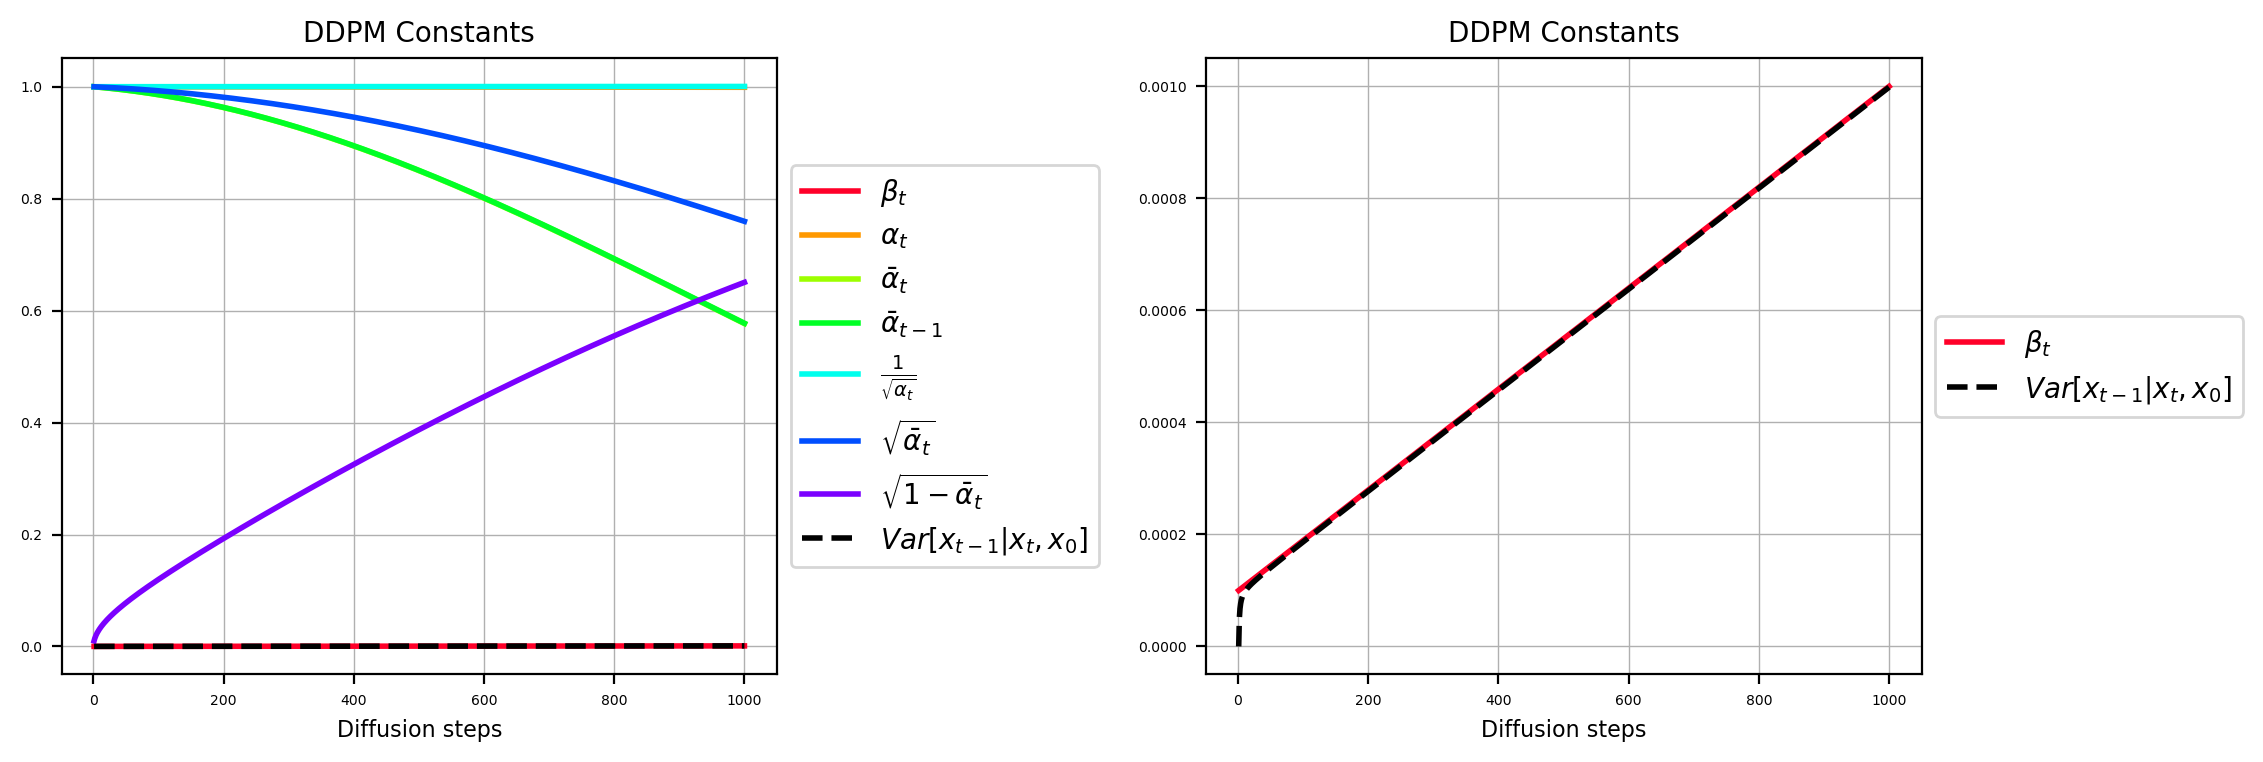

In [2]:
# Smaller `beta_end` tends to show better performances
dc = get_ddpm_constants(beta_start=1e-4,beta_end=1e-3,diffusion_step=1000)
plot_ddpm_constants(dc,figsize=(12,4))

### Correlated noise sampling using Gaussian processes

In [3]:
BATCH_SIZE,D,L = 32,1,100
times = np.linspace(start=0.0,stop=1.0,num=L).reshape((-1,1)) # [L x 1]
x_0_np = gp_sampler(times=times,hyp_gain=1.0,hyp_len=0.1,meas_std=1e-8,n_traj=D).T # [D x L]
x_0 = np2torch(x_0_np) # [D x L]
x_batch = torch.tile(x_0[None,:,:],dims=(BATCH_SIZE,1,1)) # [B x D x L]
# Set Hilbert forward process
hyp_lens = [0.1]*D # length parameter per each dimension
K_chols_np = np.zeros(shape=(D,L,L)) # [D x L x L]
for d_idx in range(D):
    hyp_len = hyp_lens[d_idx]
    K = kernel_se(times,times,hyp={'gain':1.0,'len':hyp_len})
    K_chols_np[d_idx,:,:] = np.linalg.cholesky(K+1e-8*np.eye(L,L)) # [L x L]
K_chols = np2torch(K_chols_np) # [D x L x L]
# Set RHKS projections
RKHS_projs_np = np.zeros(shape=(D,L,L)) # [D x L x L]
for d_idx in range(D):
    hyp_len = hyp_lens[d_idx]
    RKHS_projs_np[d_idx,:,:] = get_rkhs_proj(times=times,hyp_len=hyp_len,meas_std=1e-6) # [L x L]
RKHS_projs = np2torch(RKHS_projs_np) # [D x L x L]
# Model
model = DenoisingDenseUNetClass(
    D=D,L=L,pos_emb_dim=32,h_dims=[128,64,32],z_dim=32,
    actv=nn.GELU(), # nn.GELU(), nn.ReLU()
    USE_POS_EMB=True,RKHS_projs=RKHS_projs)
print ("Ready.")

Ready.


### Train

[0/10000][0.00%] loss:[0.907]


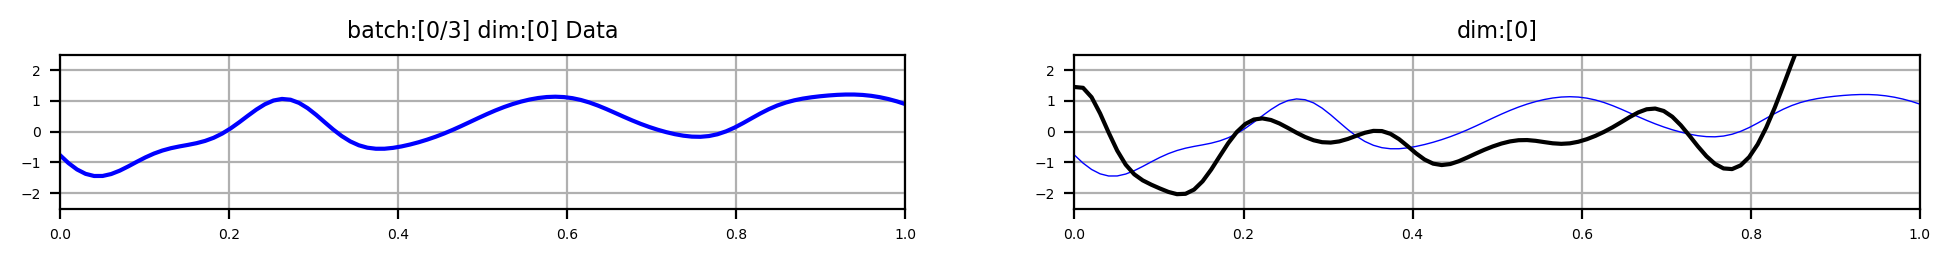

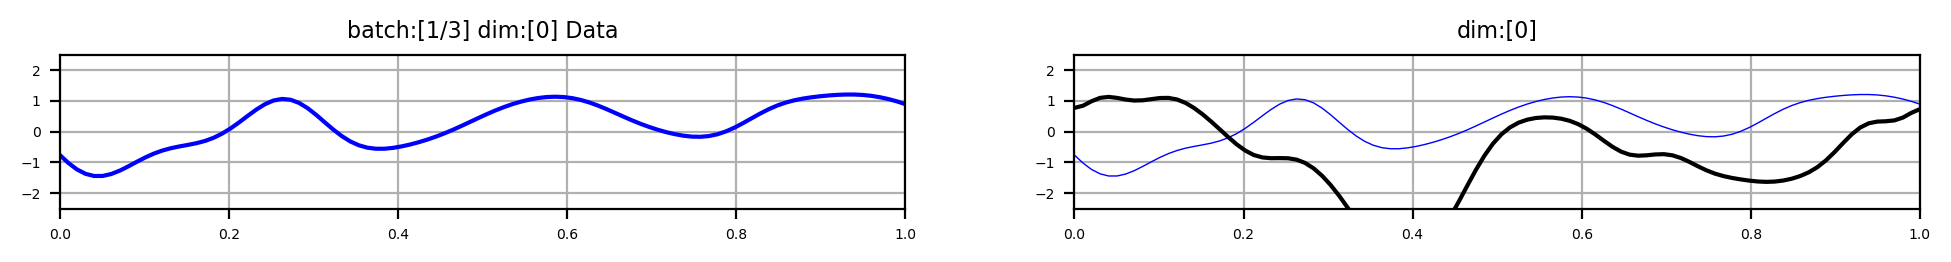

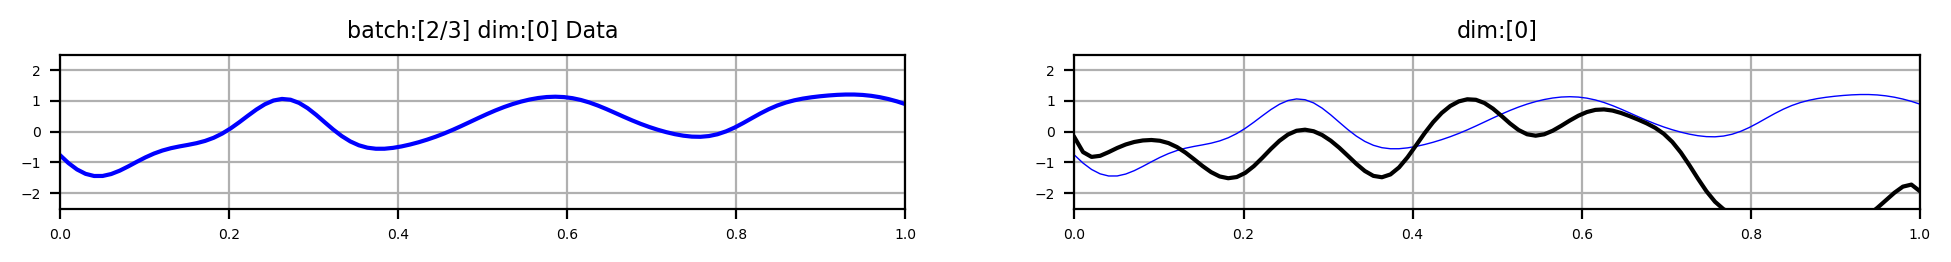

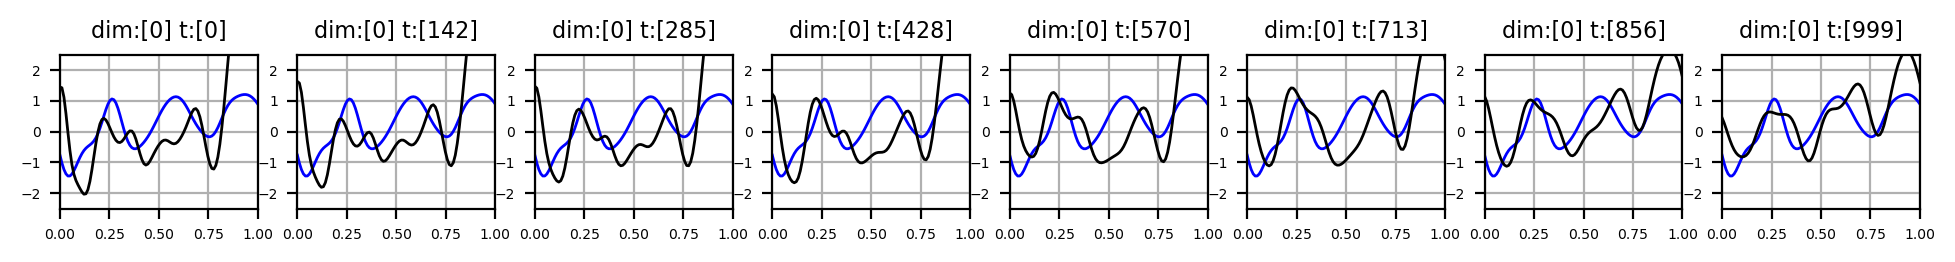

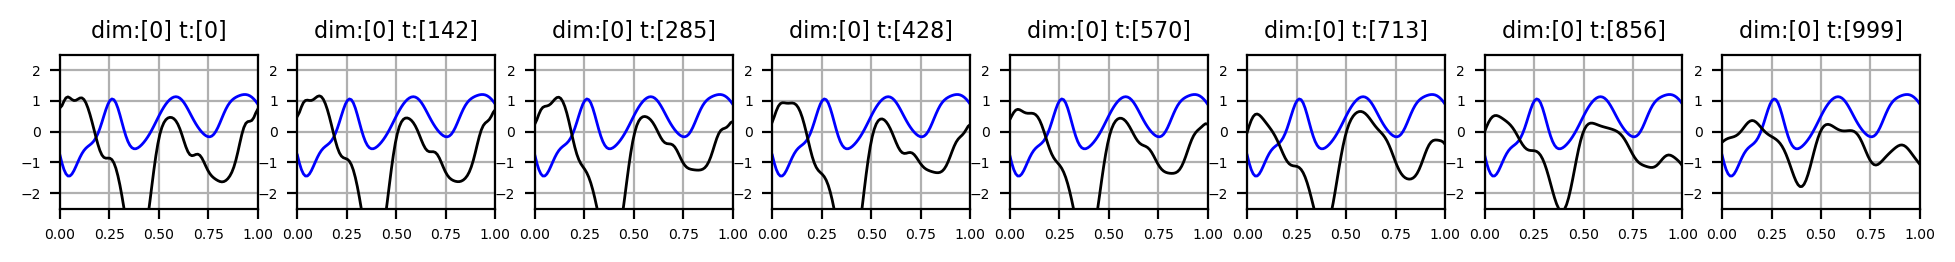

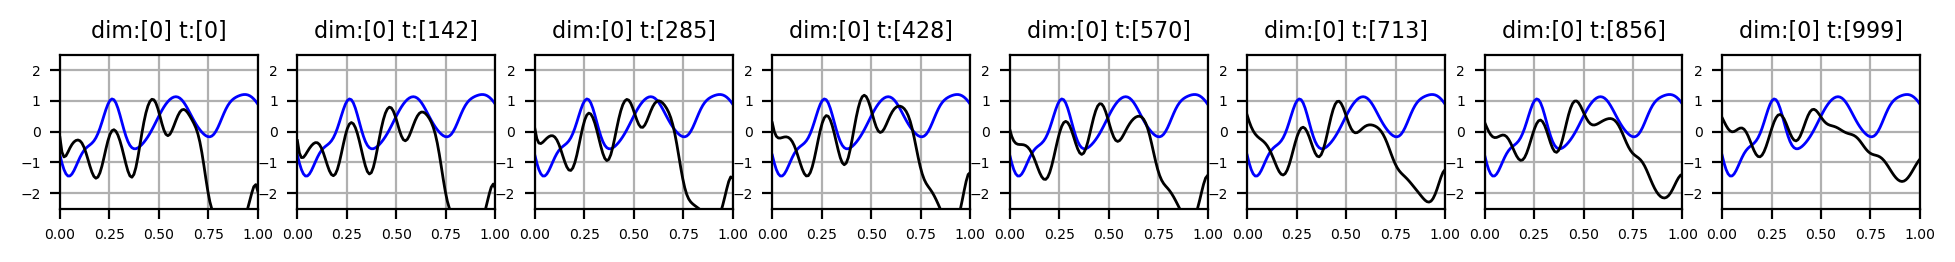

[1000/10000][10.00%] loss:[0.193]


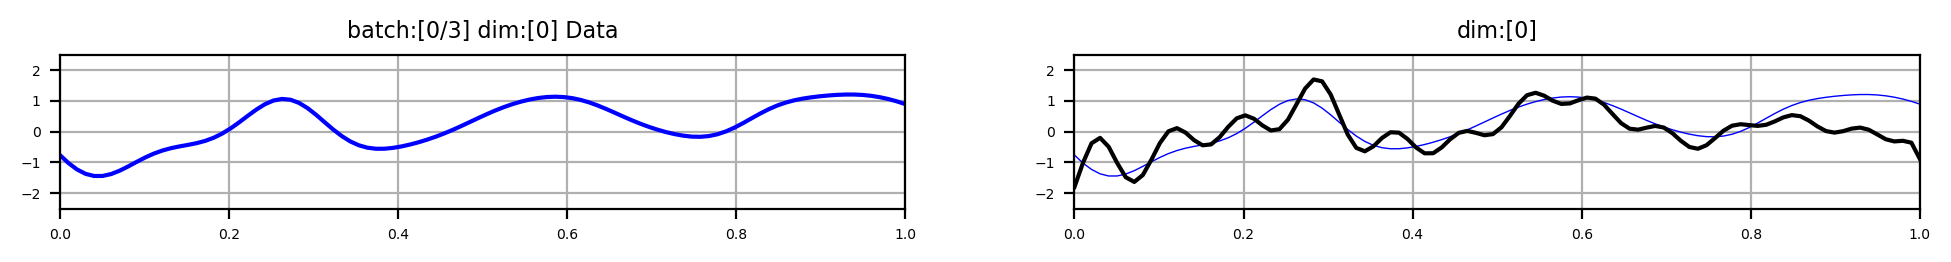

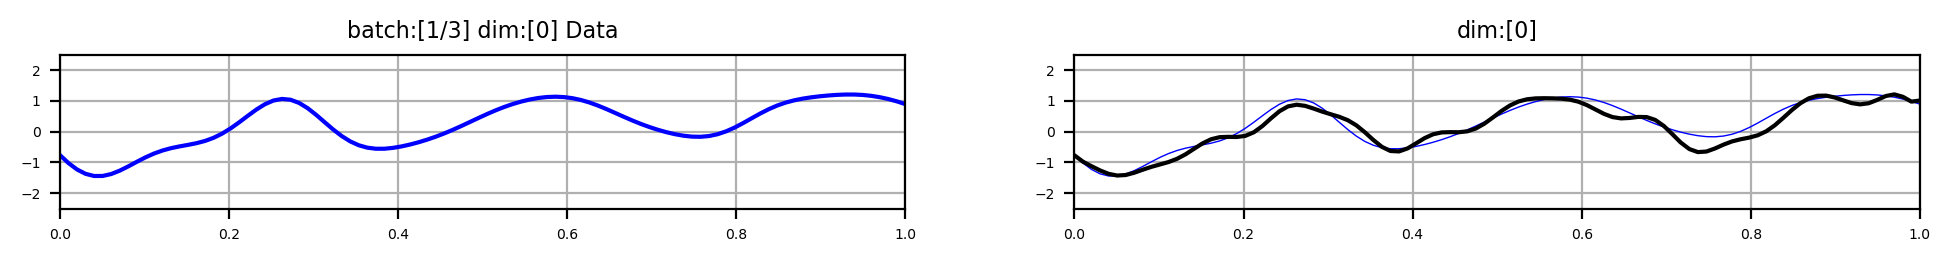

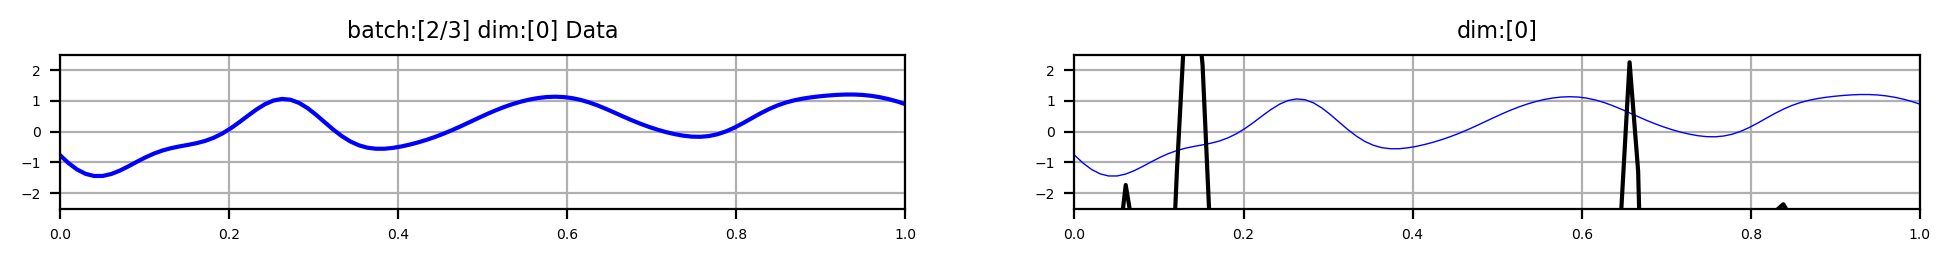

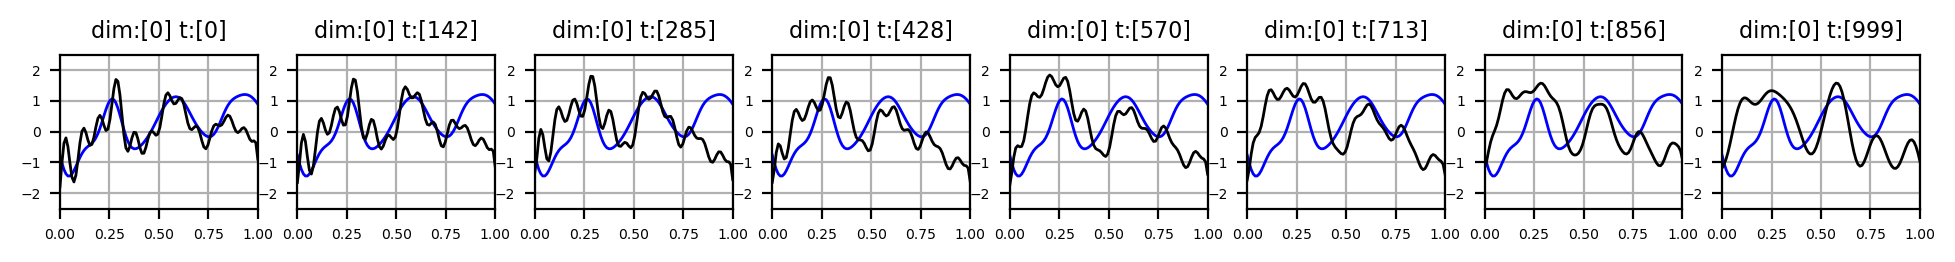

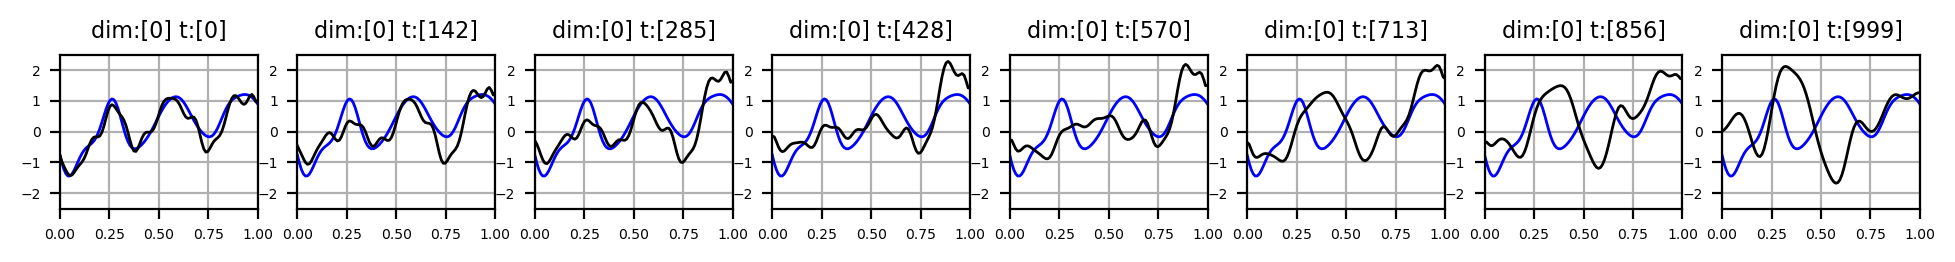

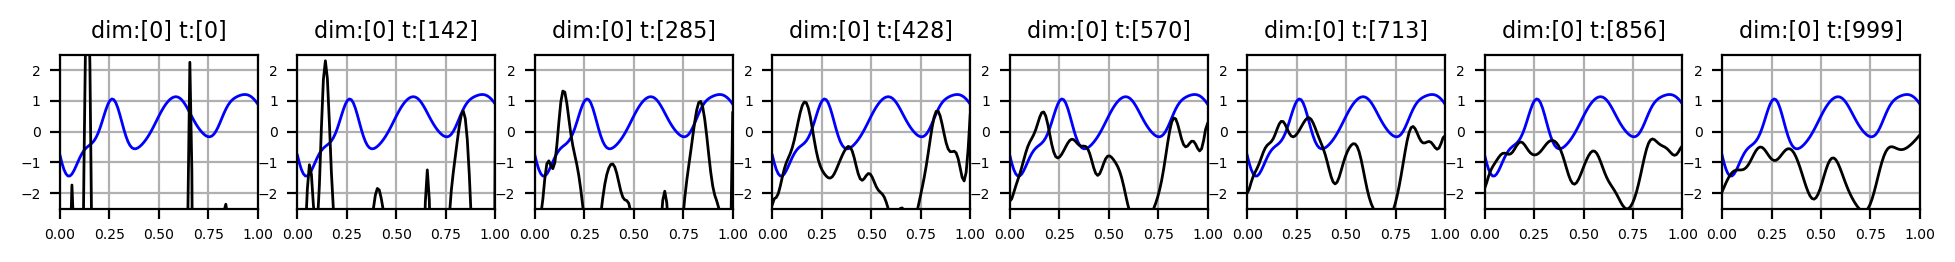

[2000/10000][20.00%] loss:[0.121]


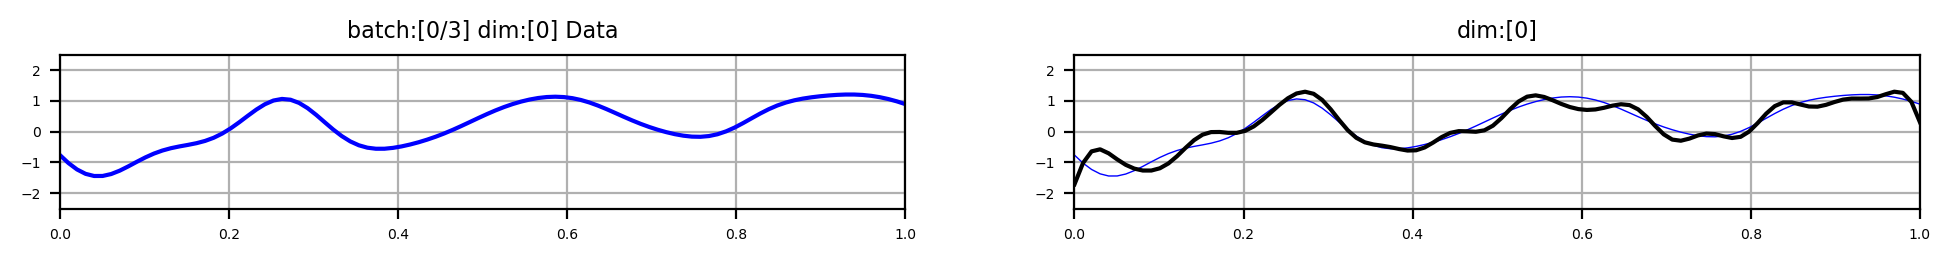

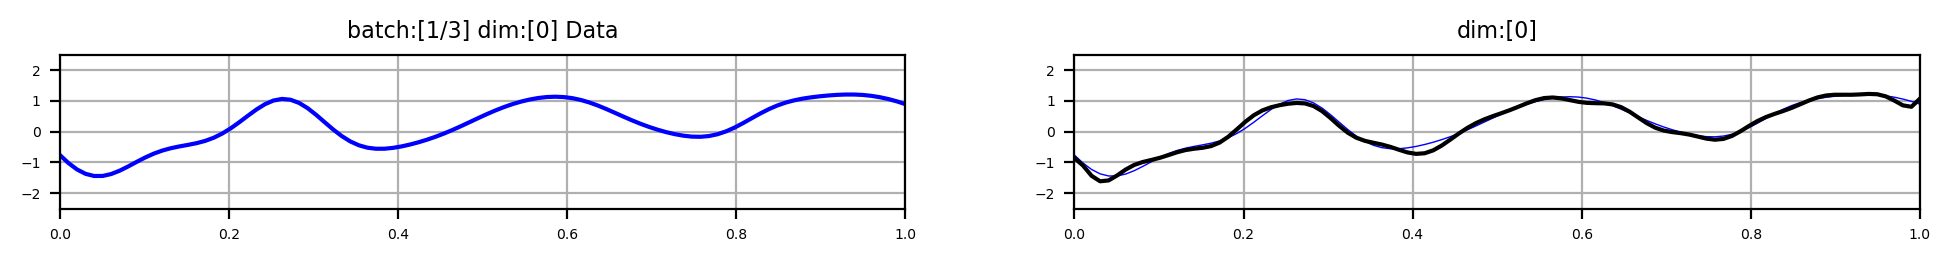

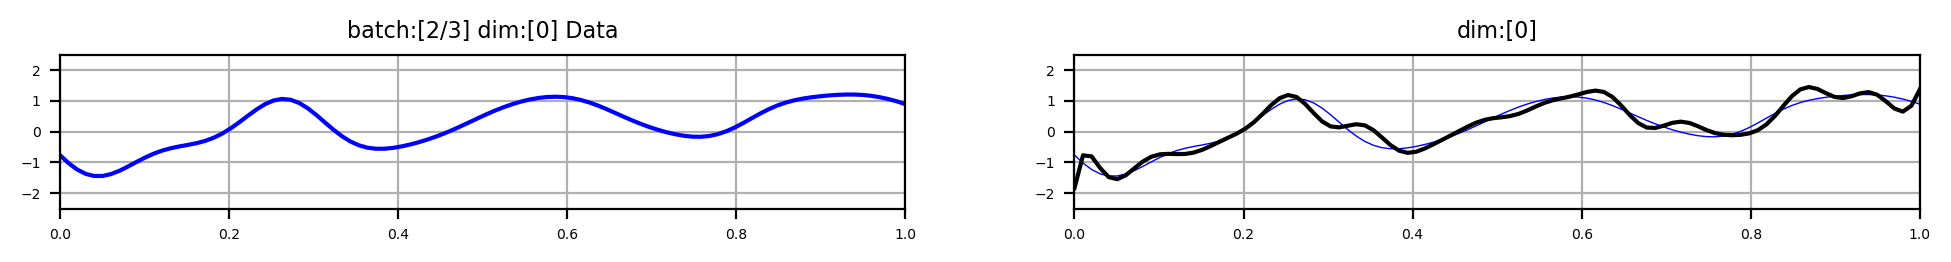

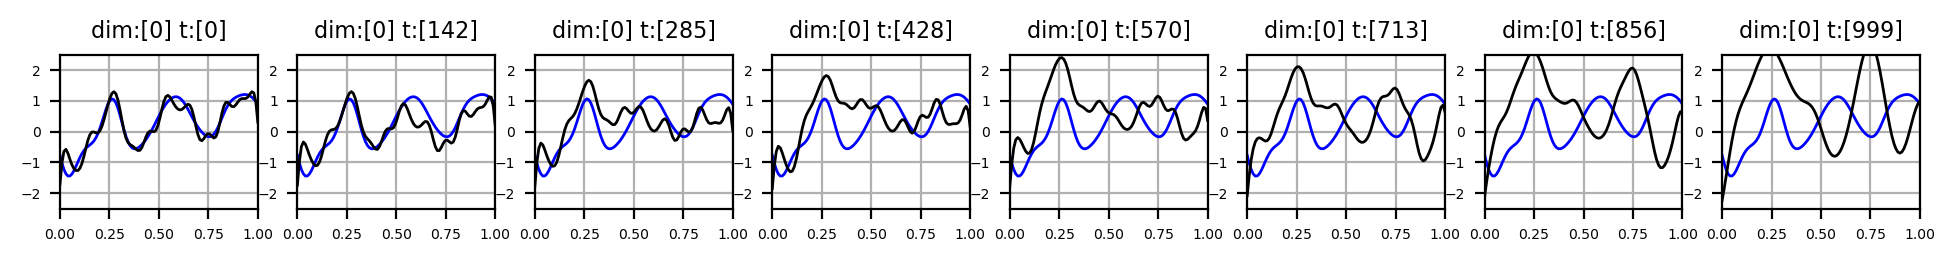

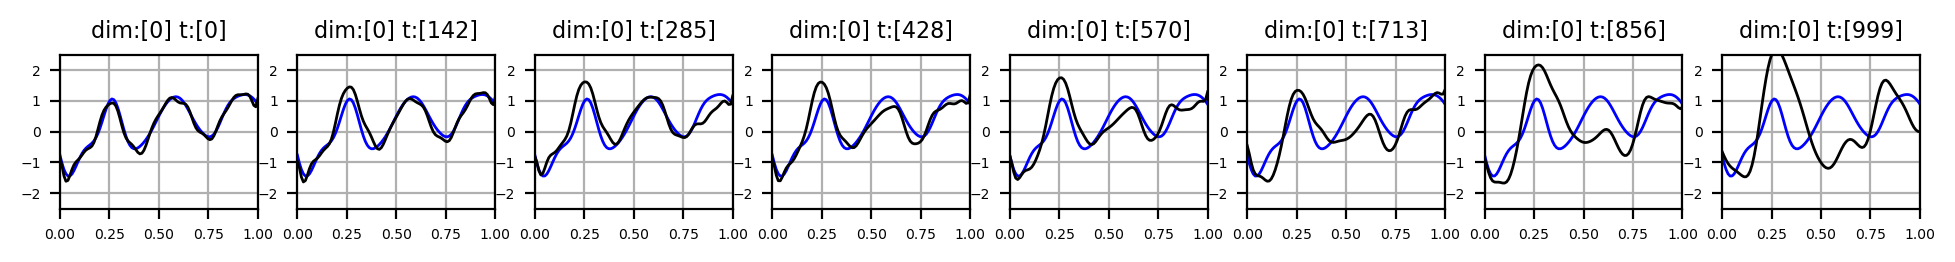

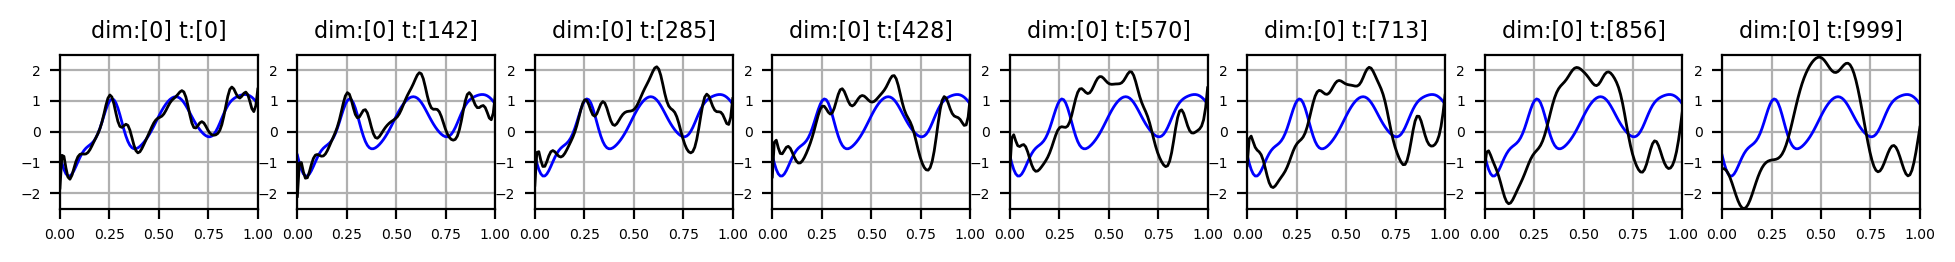

[3000/10000][30.00%] loss:[0.127]


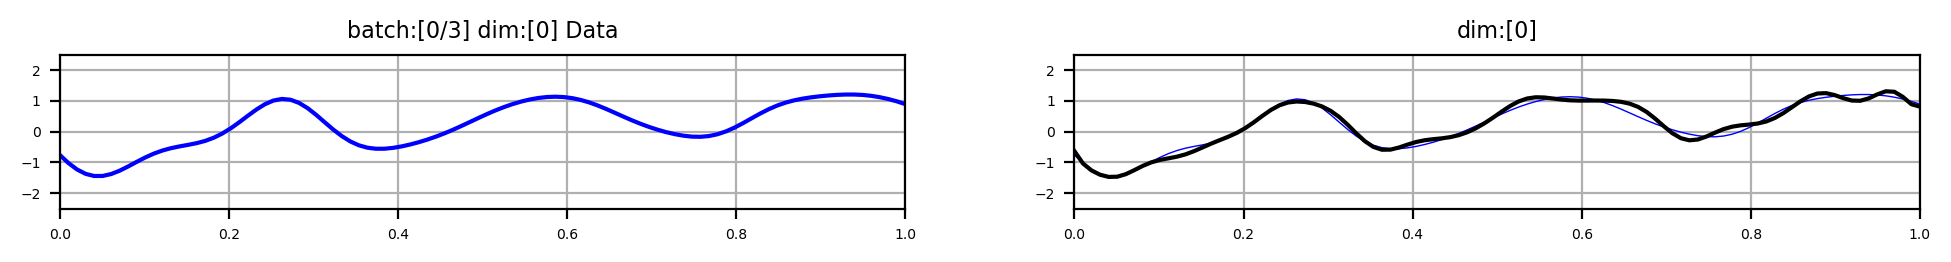

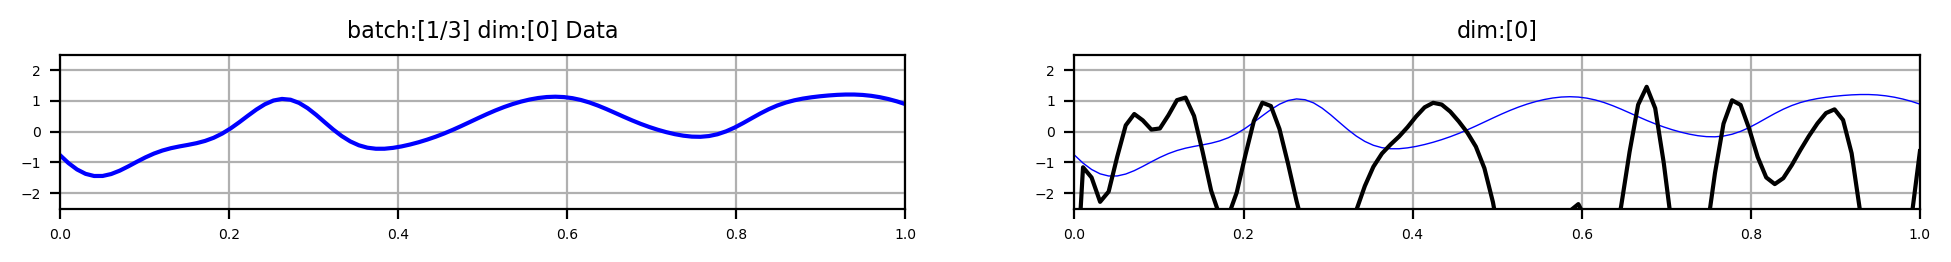

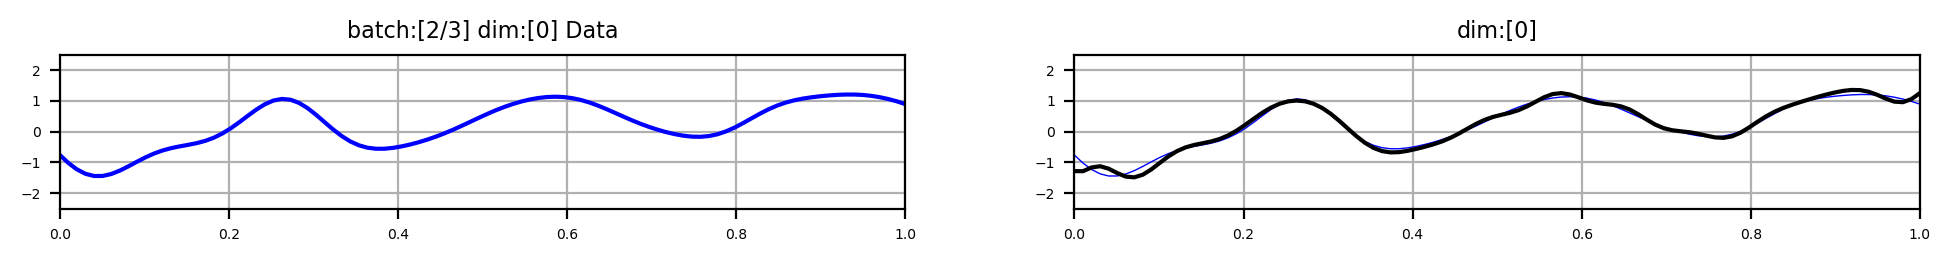

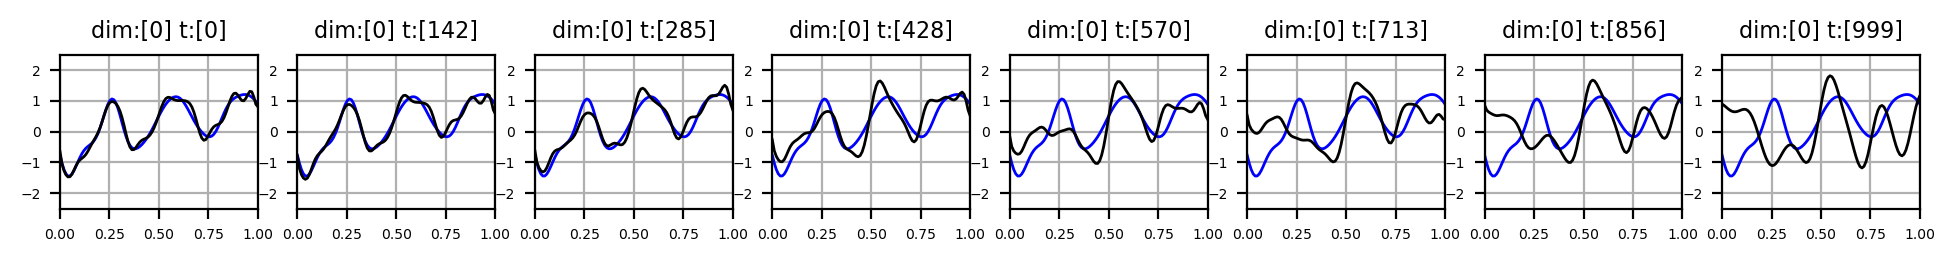

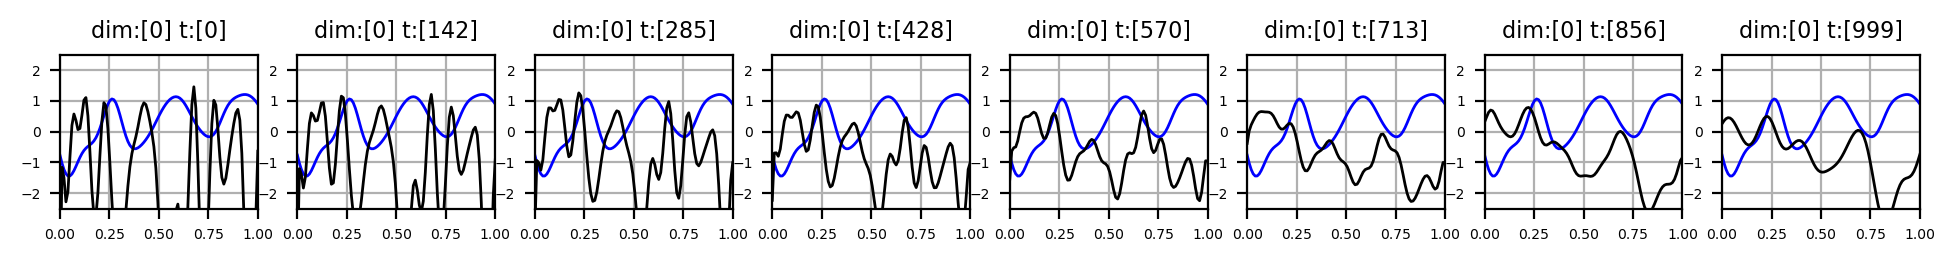

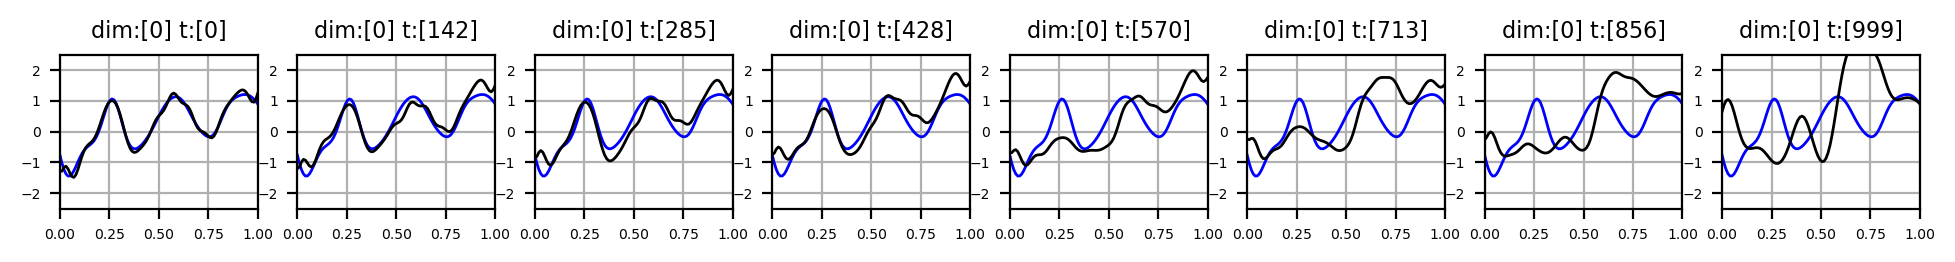

[4000/10000][40.00%] loss:[0.105]


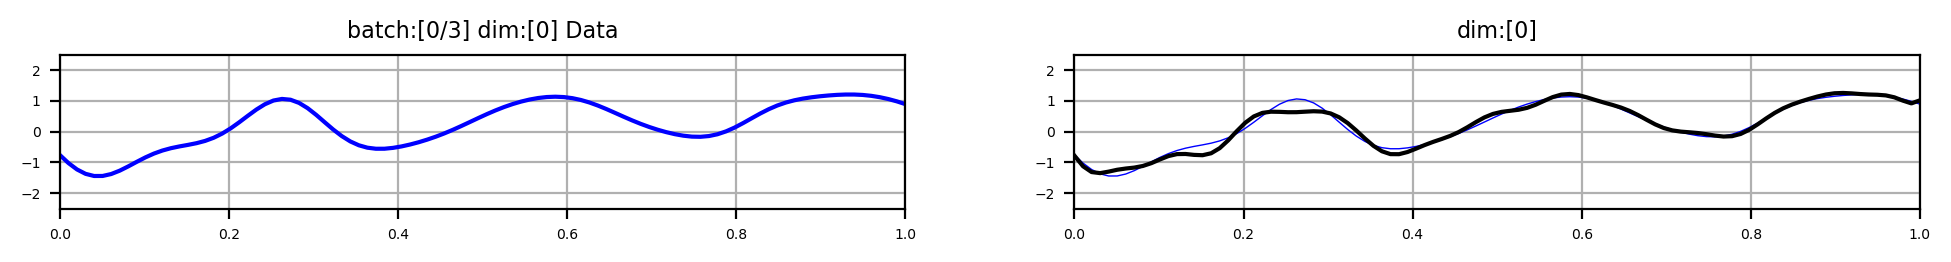

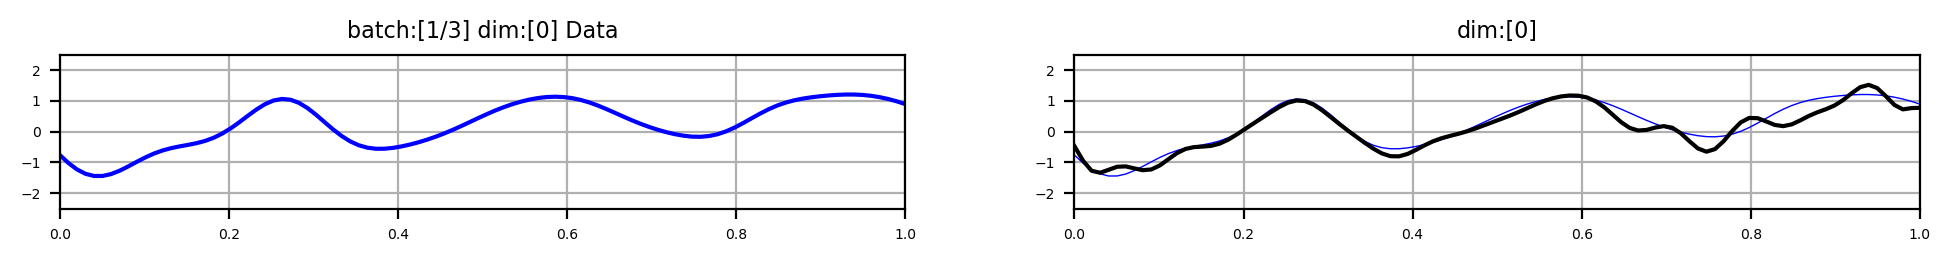

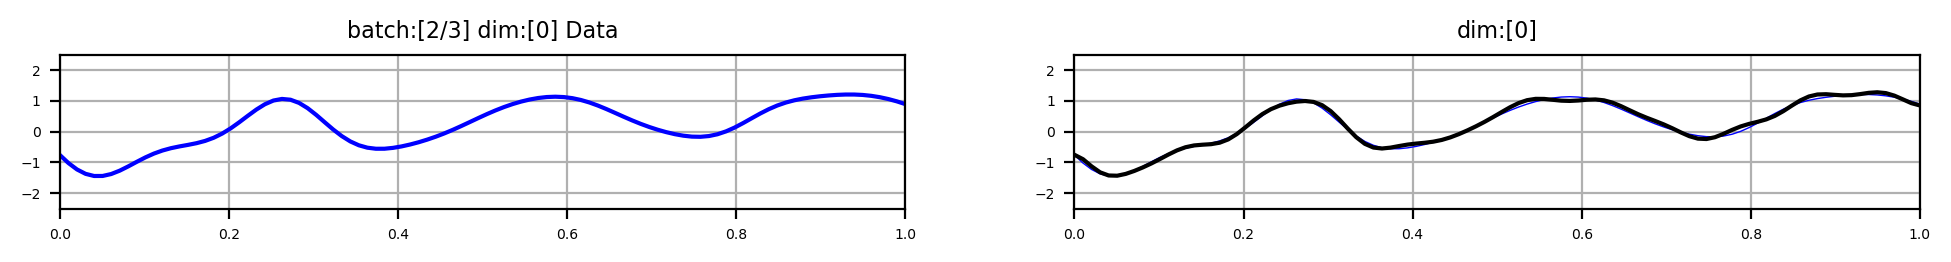

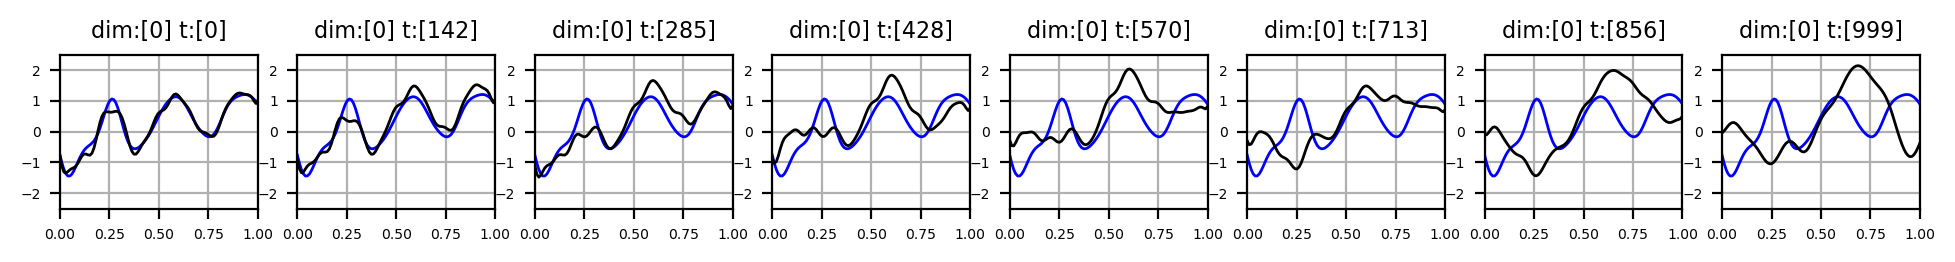

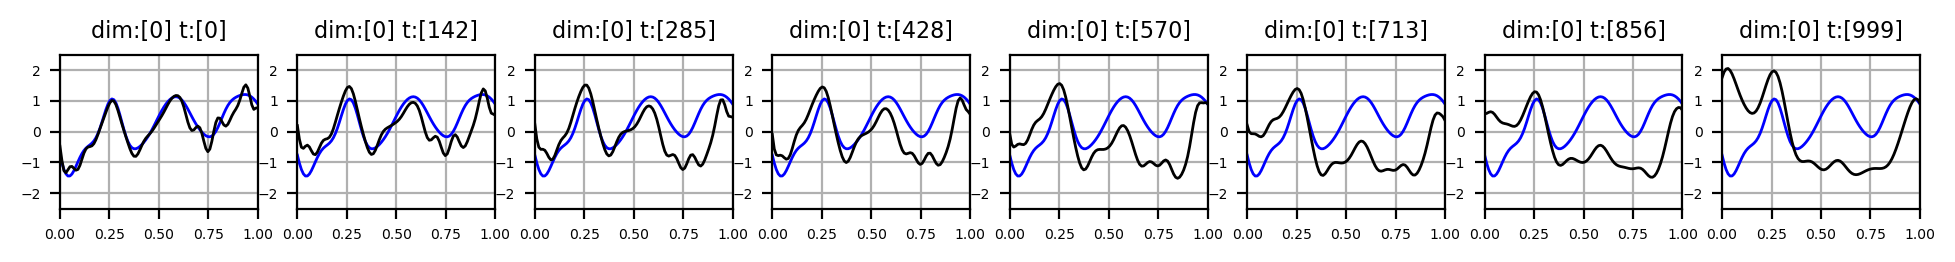

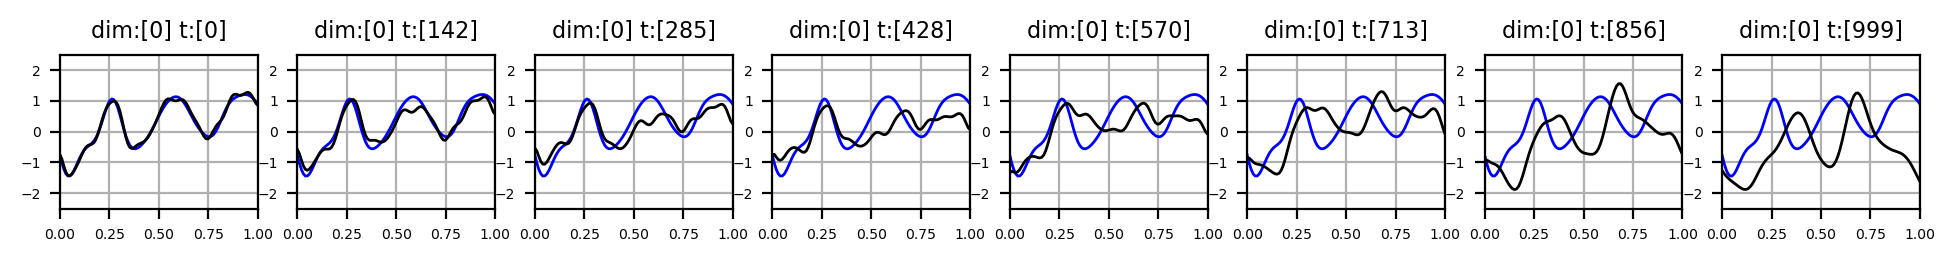

[5000/10000][50.00%] loss:[0.118]


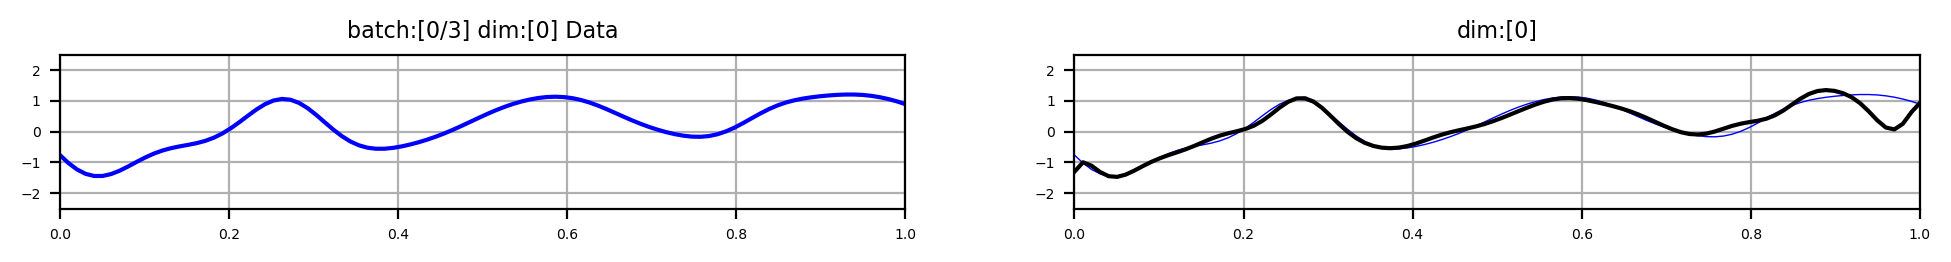

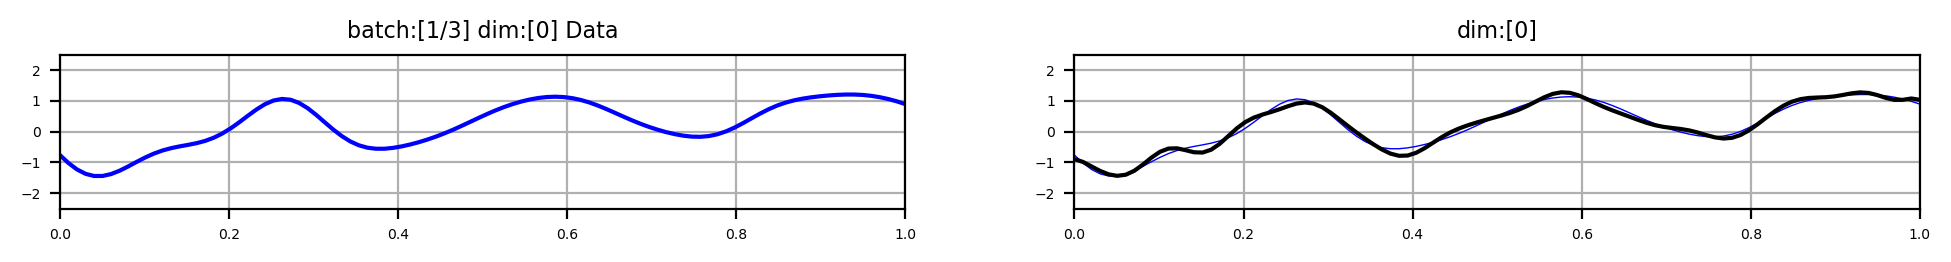

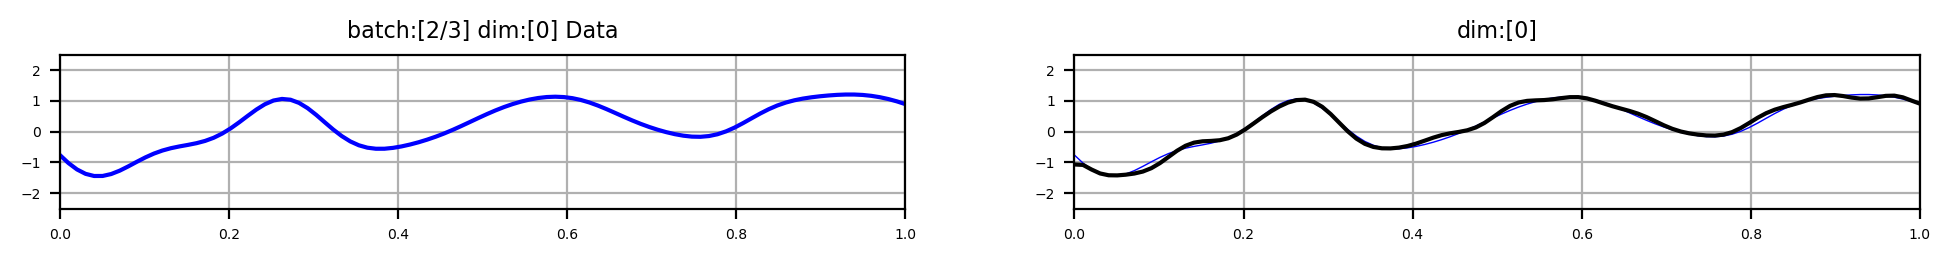

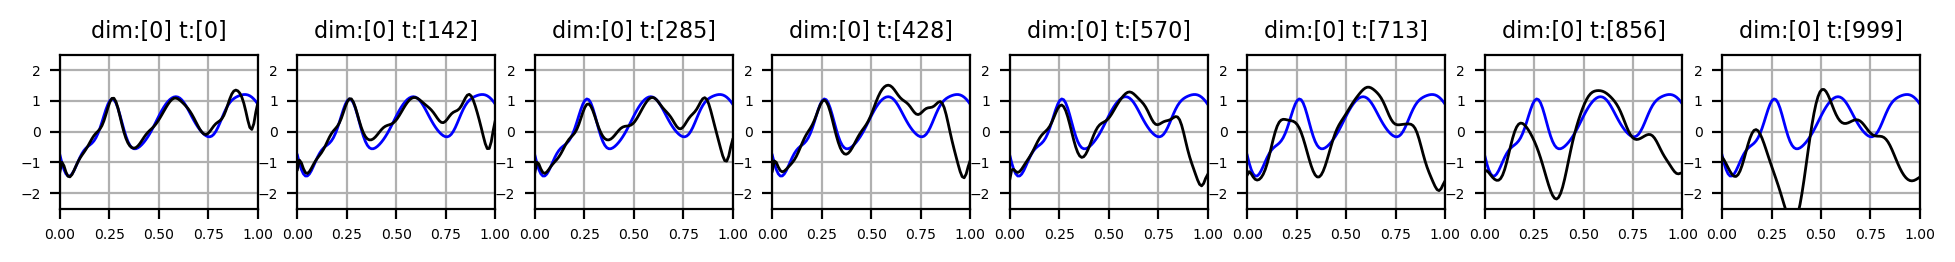

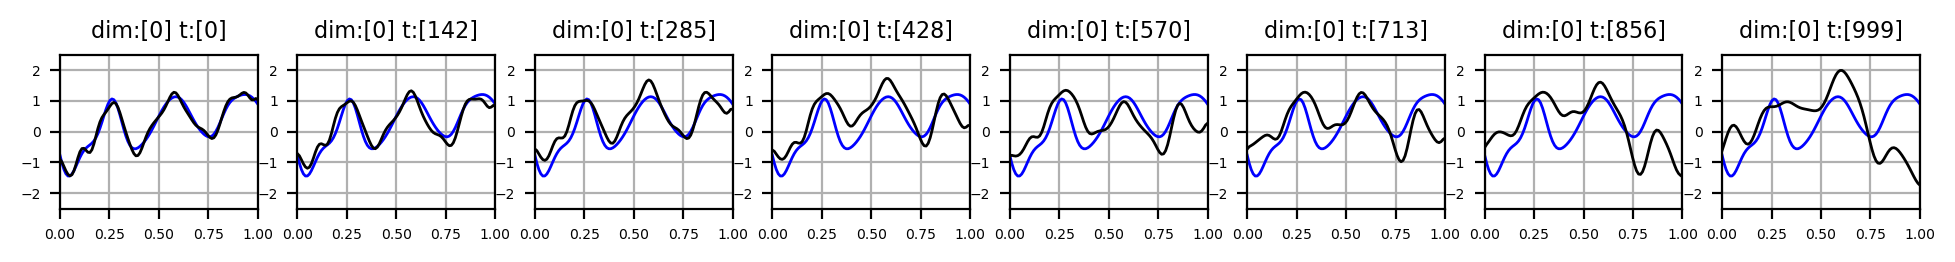

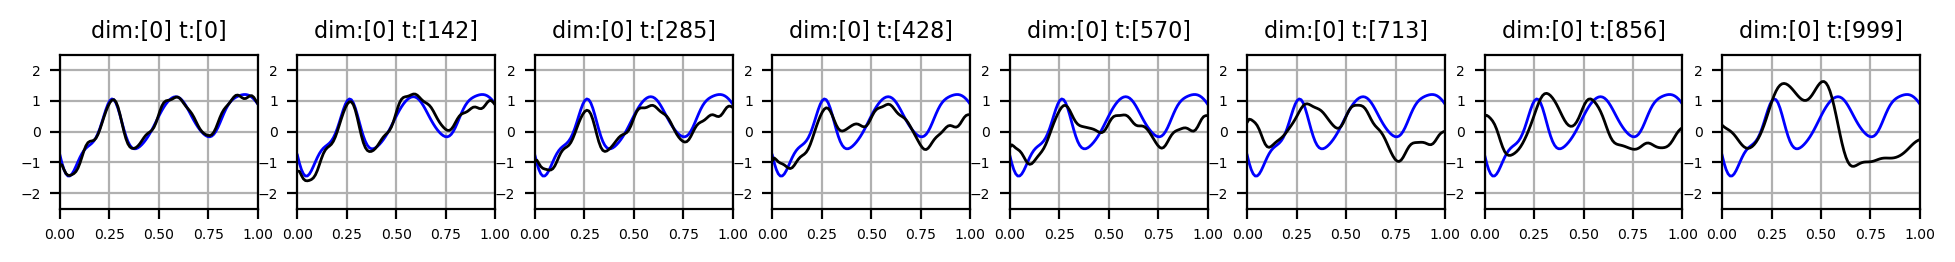

[6000/10000][60.00%] loss:[0.129]


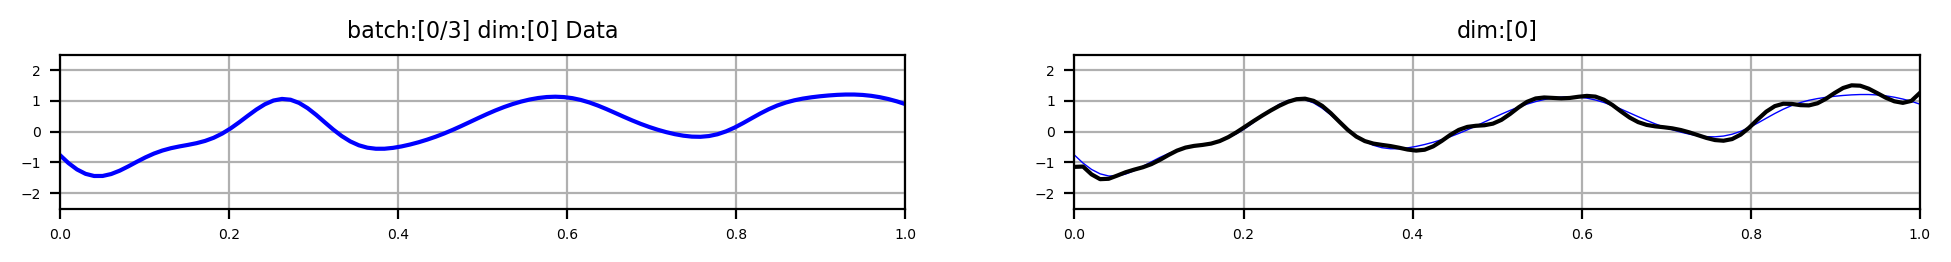

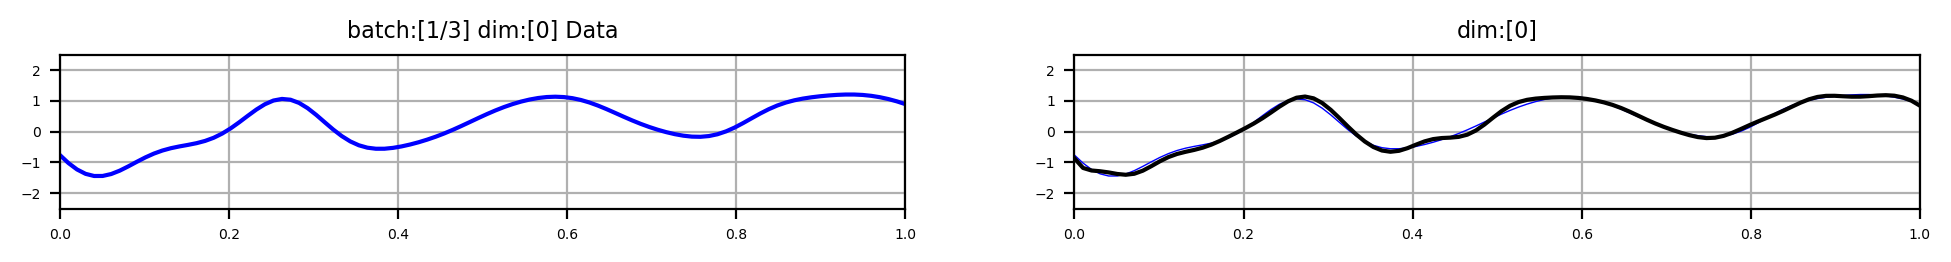

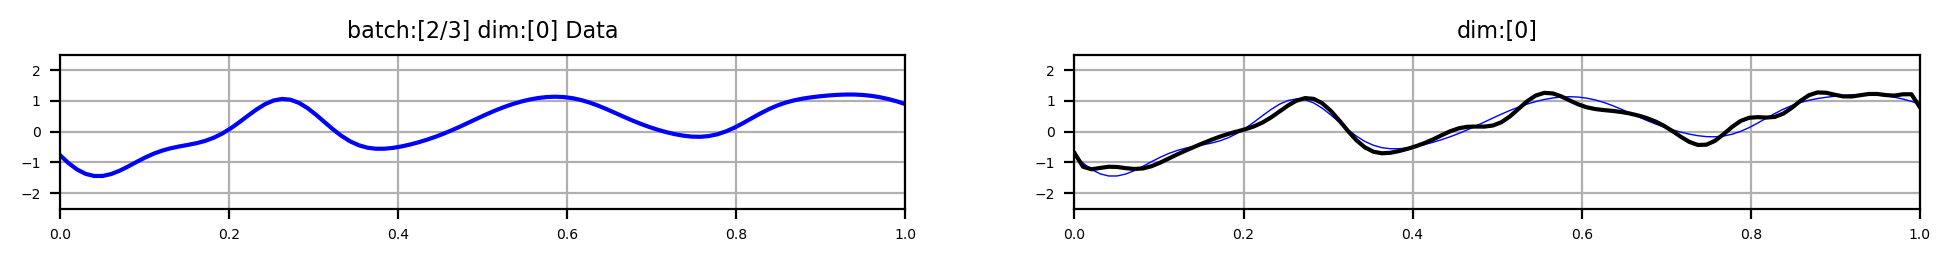

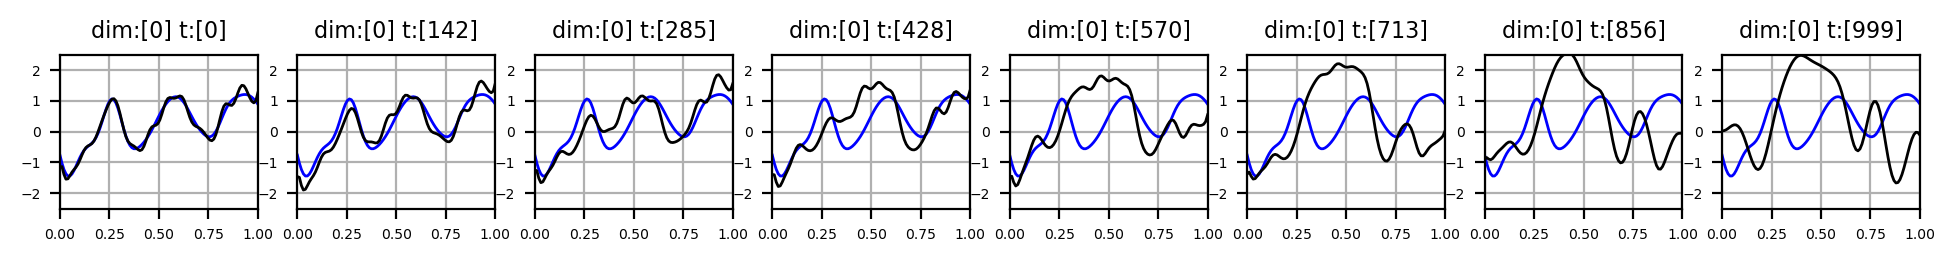

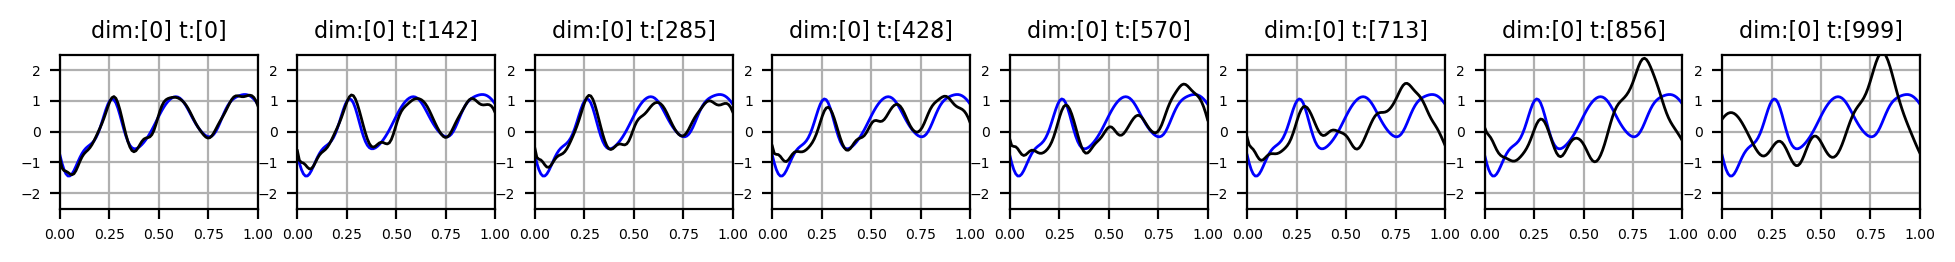

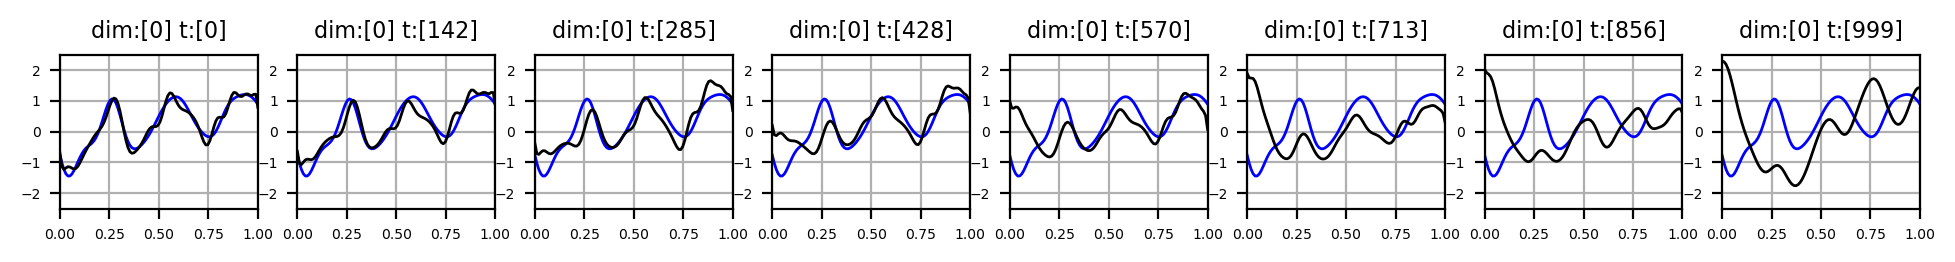

[7000/10000][70.00%] loss:[0.126]


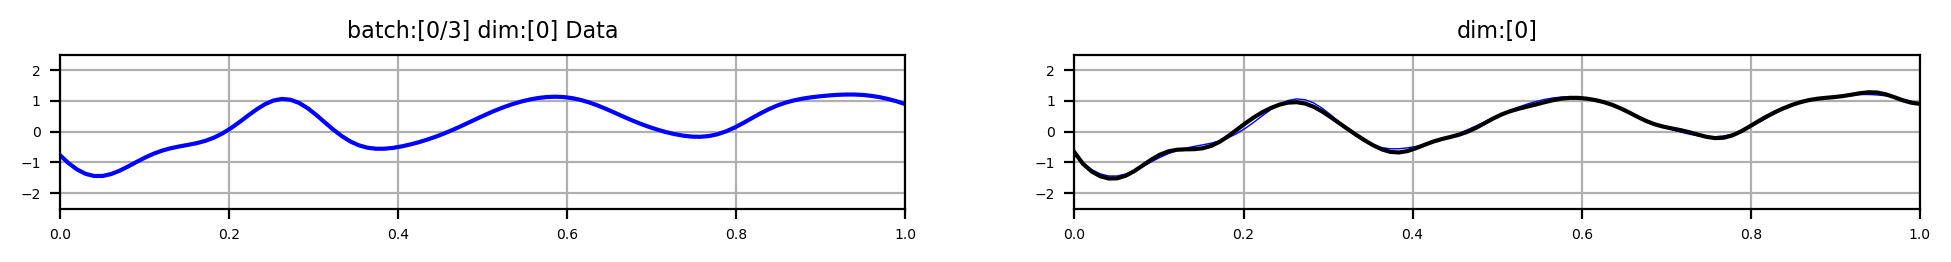

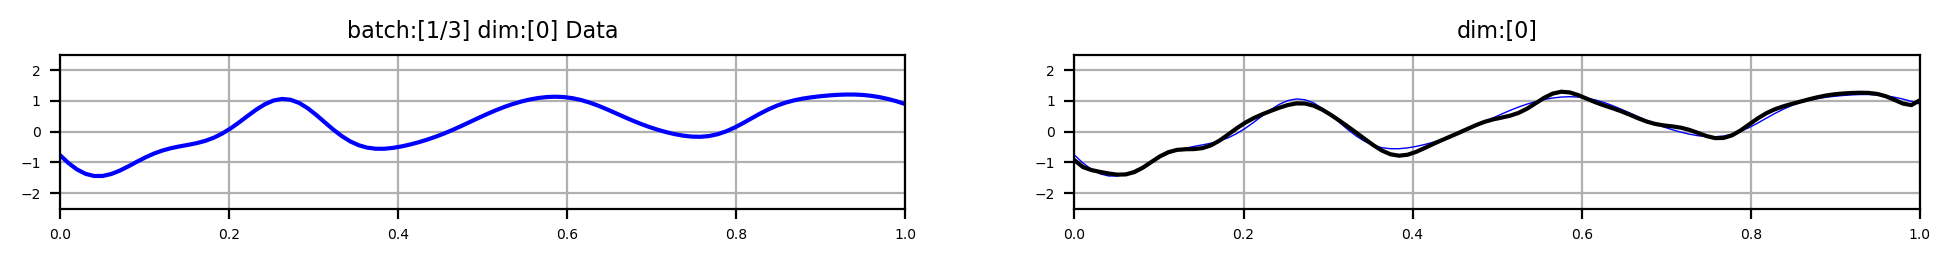

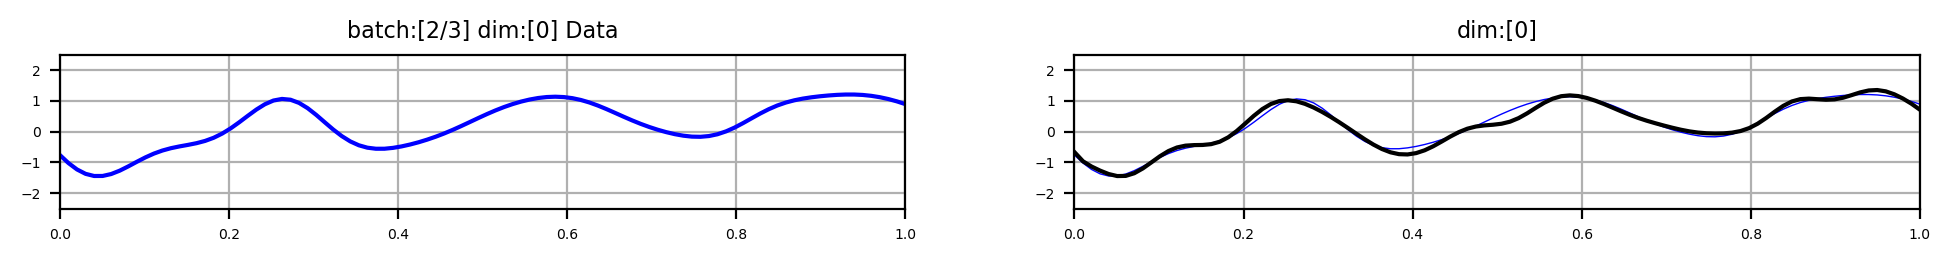

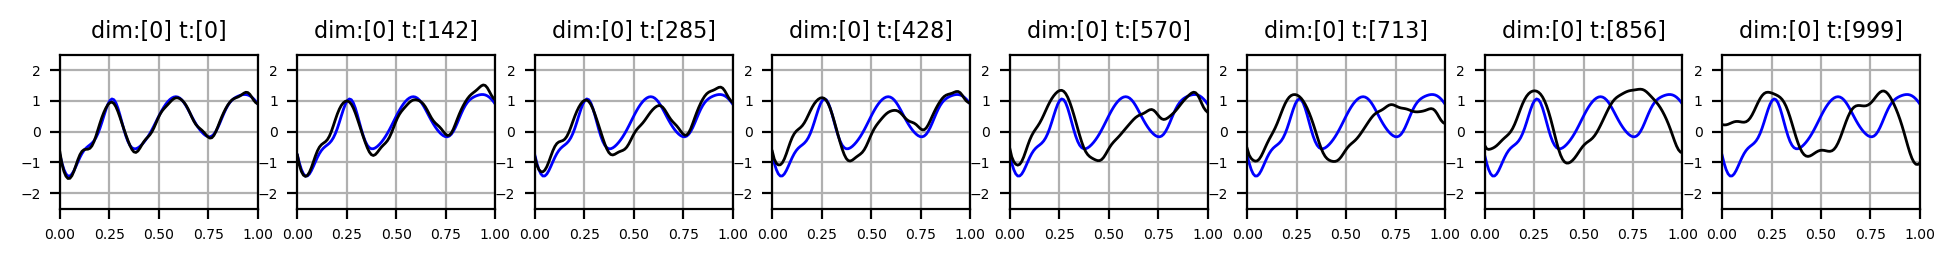

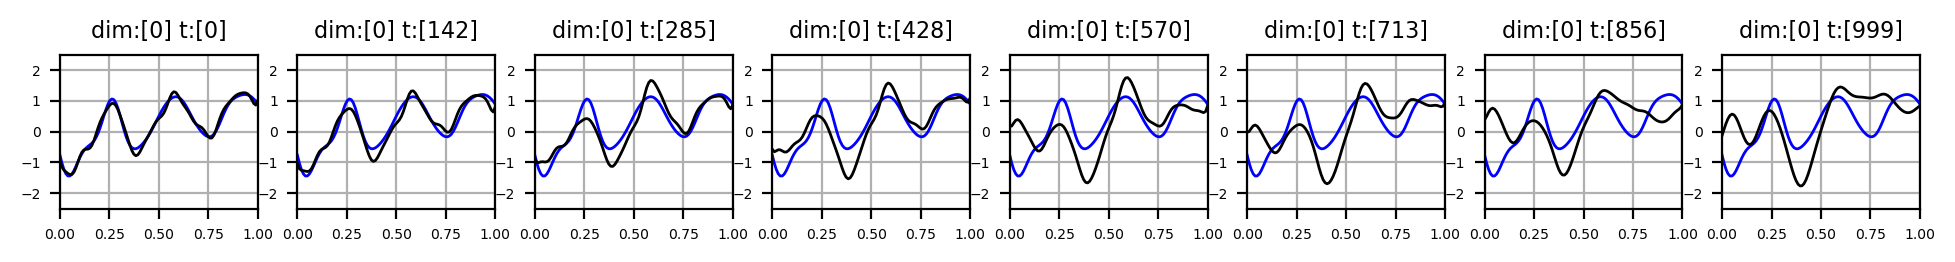

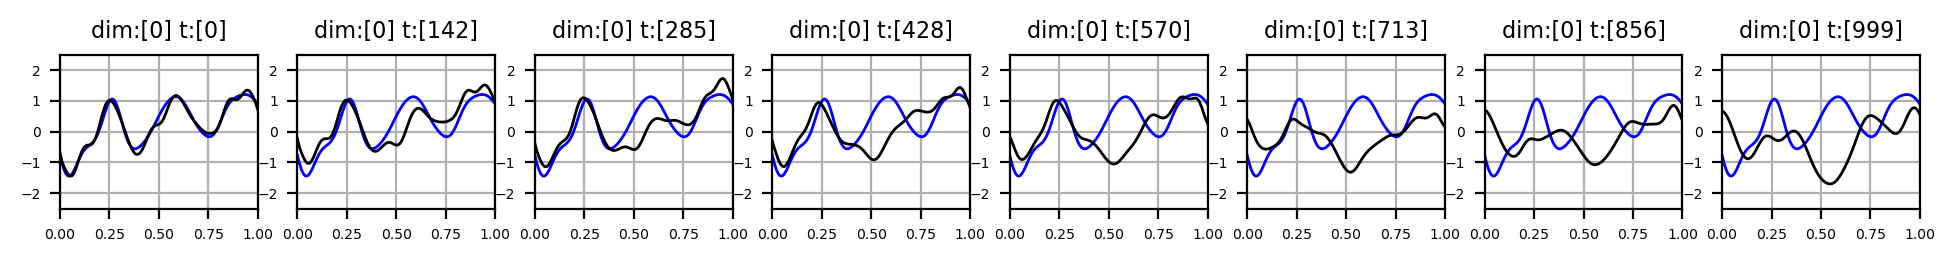

[8000/10000][80.00%] loss:[0.135]


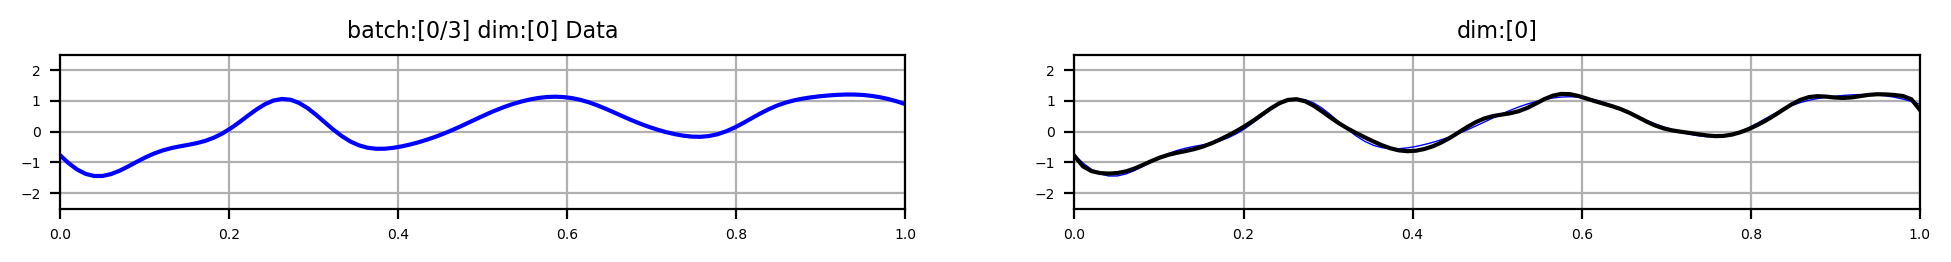

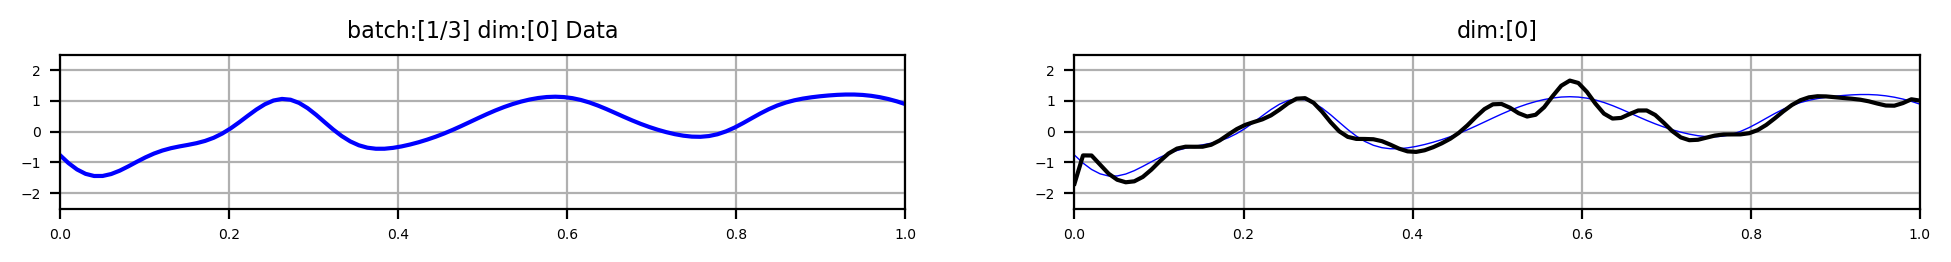

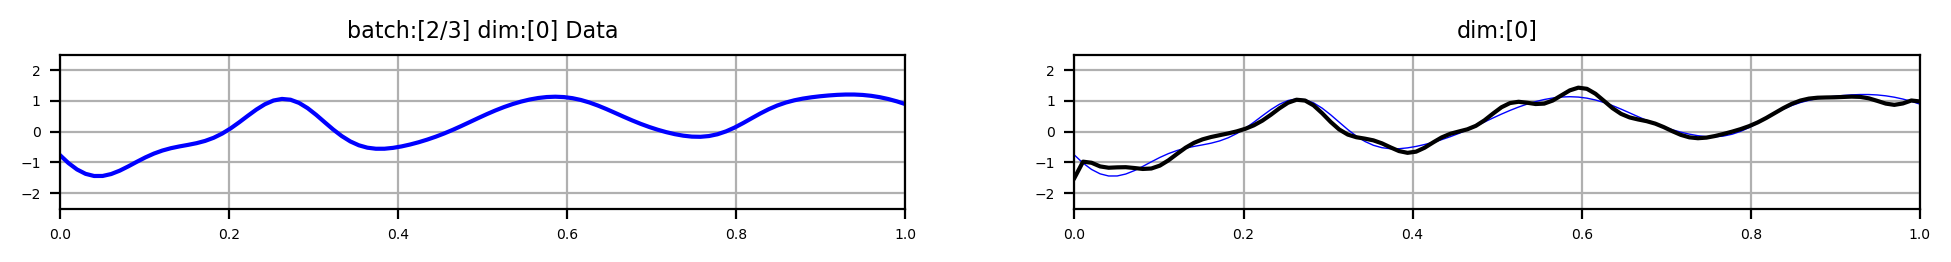

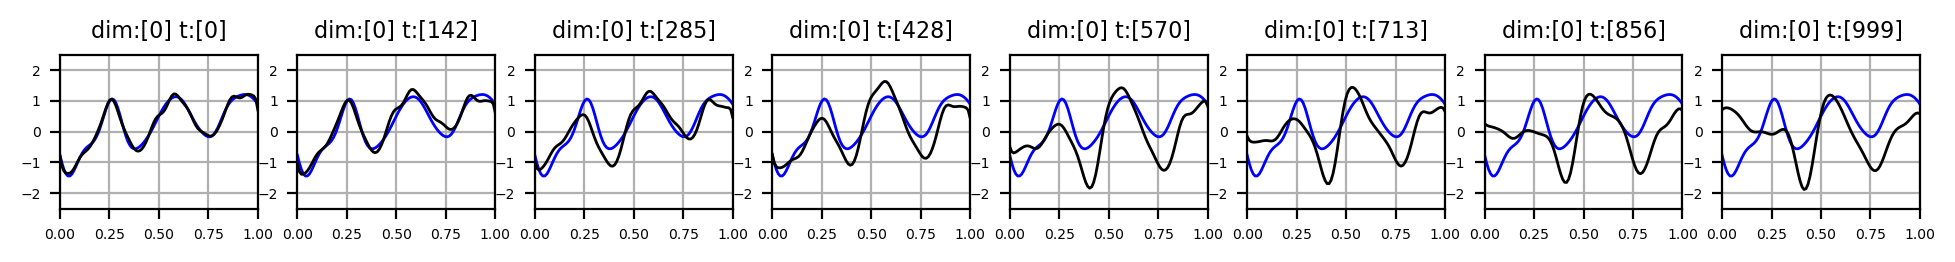

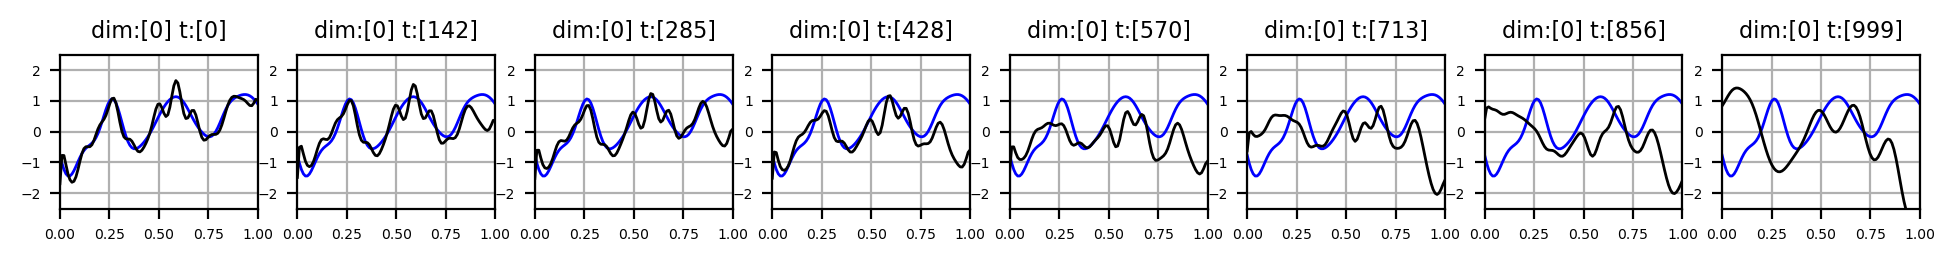

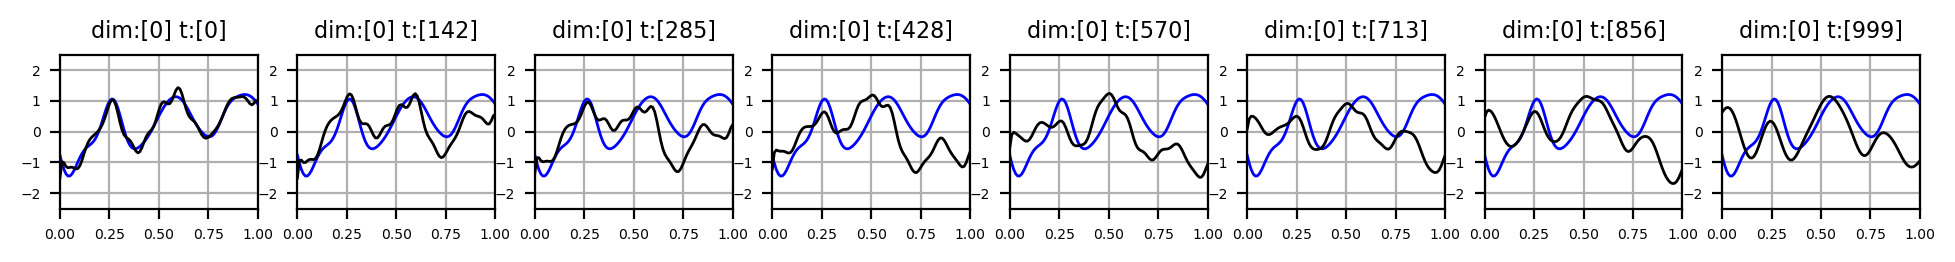

[9000/10000][90.00%] loss:[0.094]


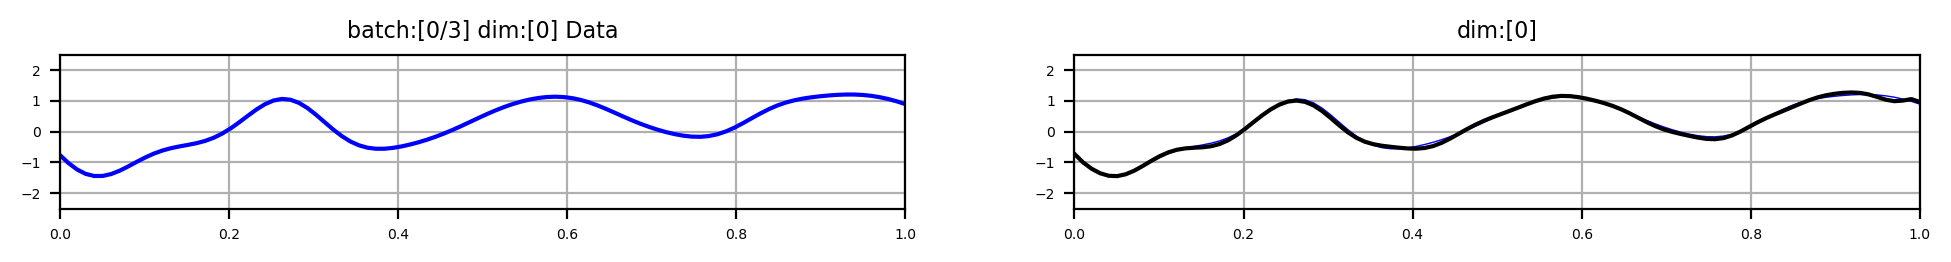

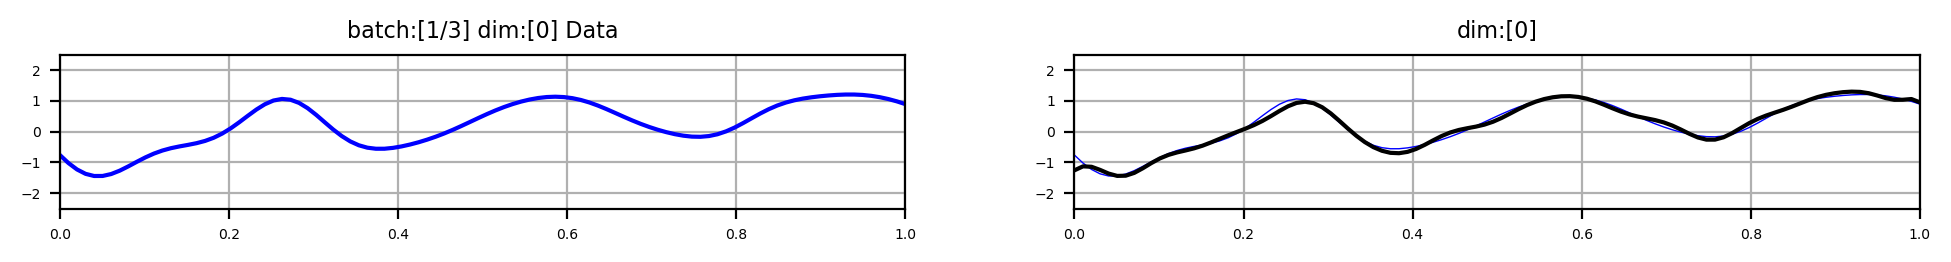

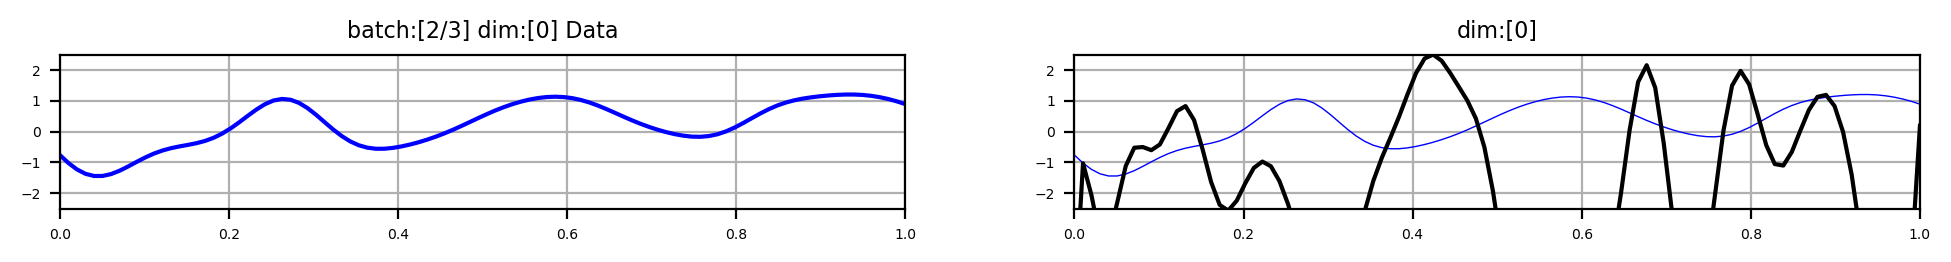

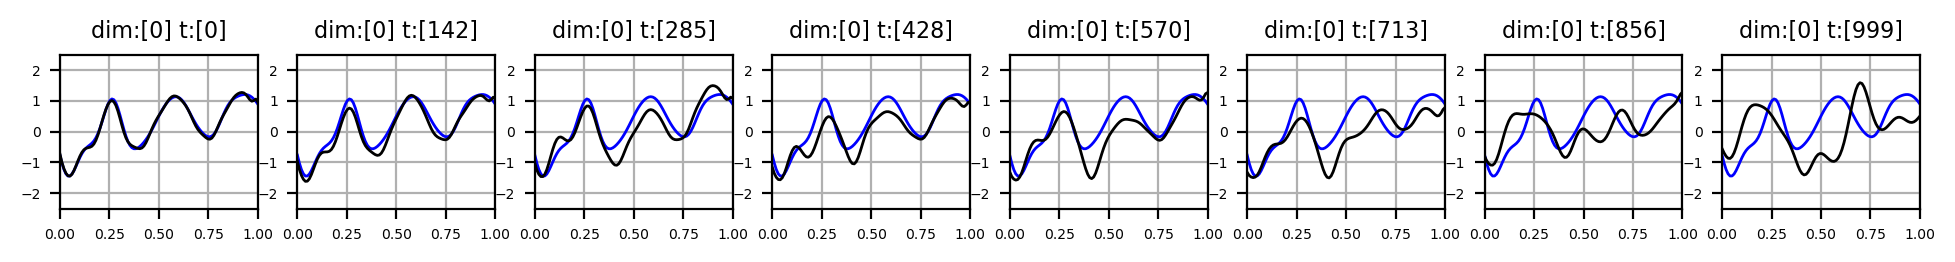

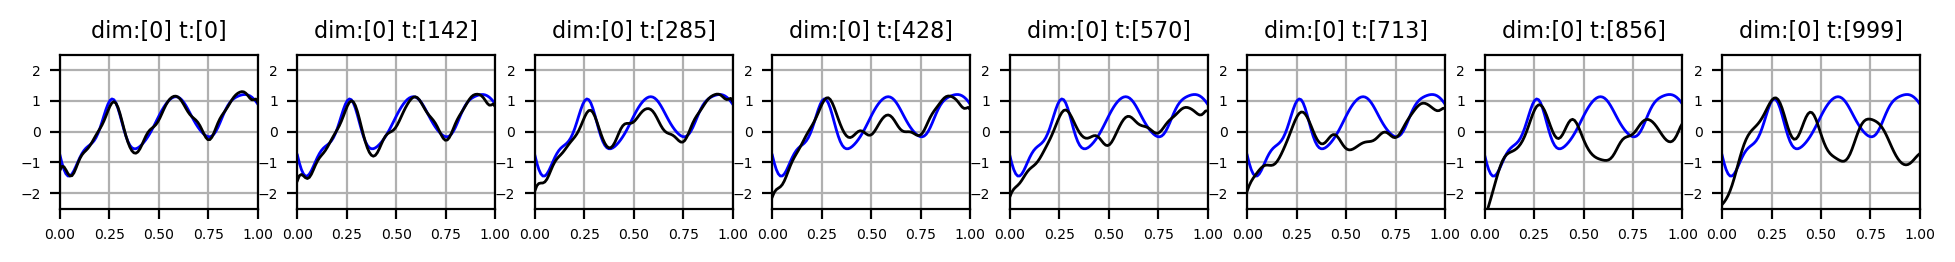

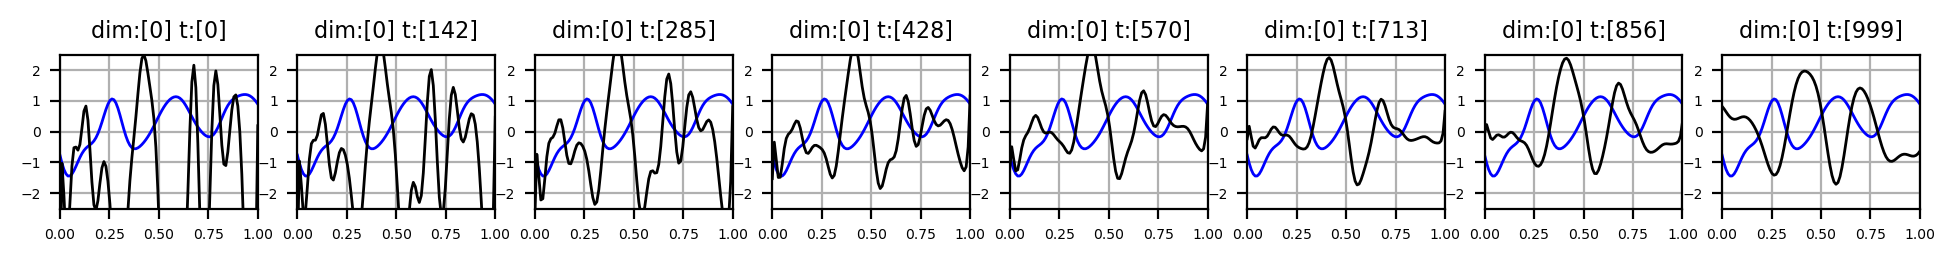

[9999/10000][99.99%] loss:[0.105]


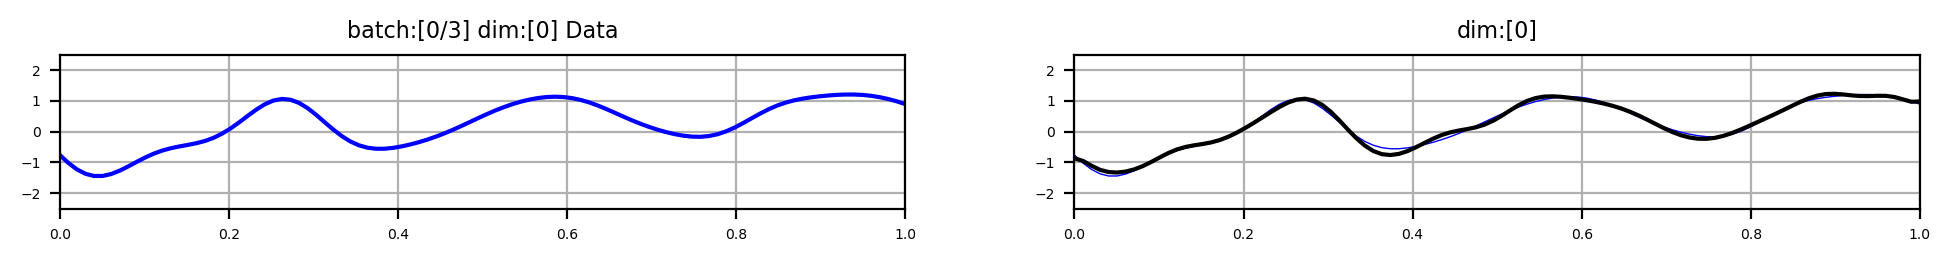

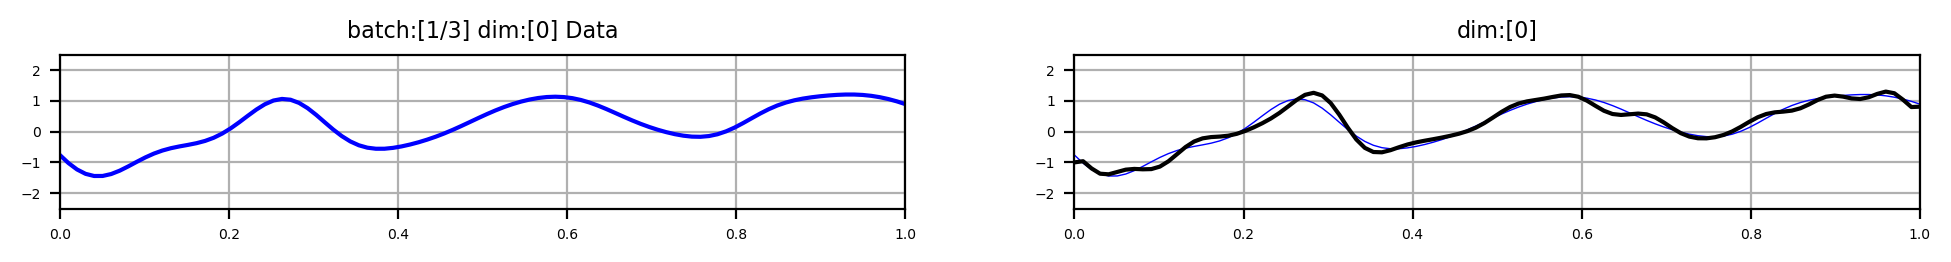

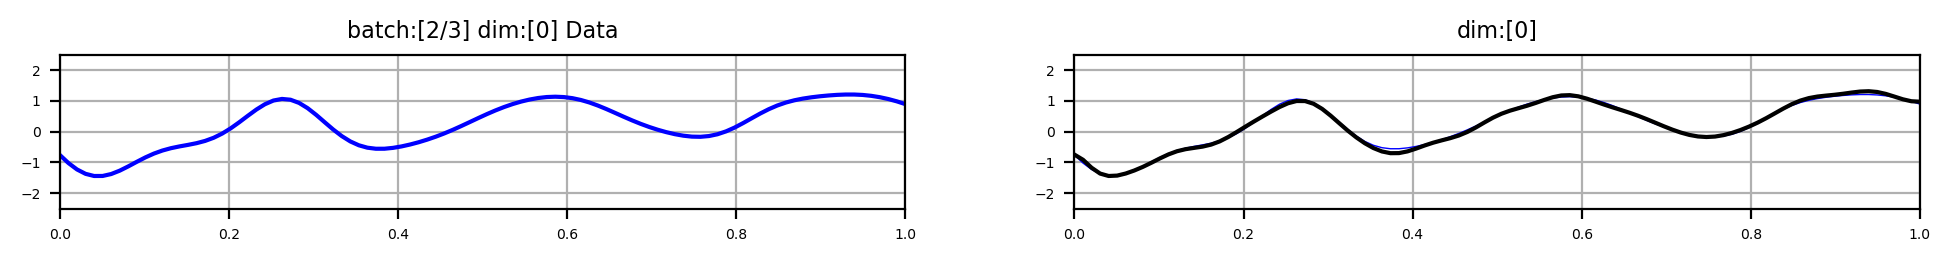

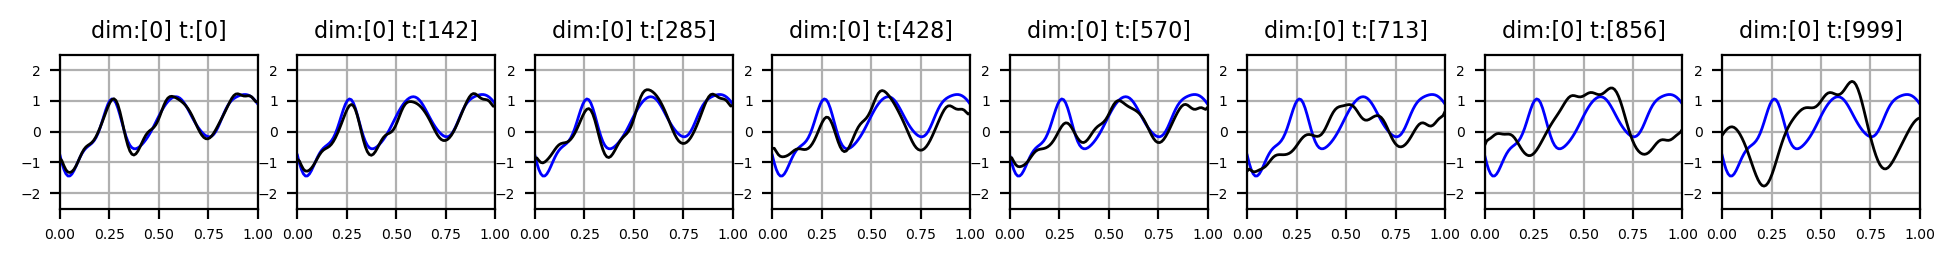

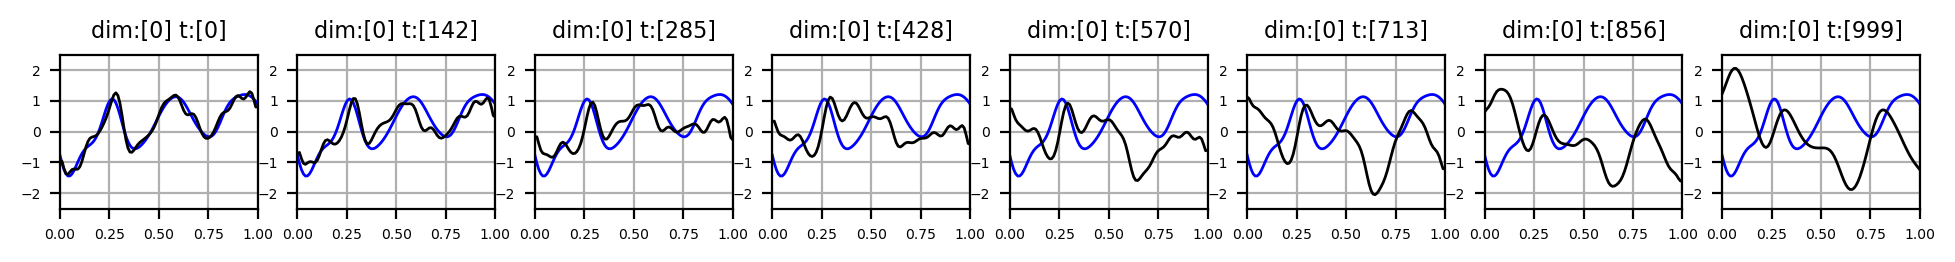

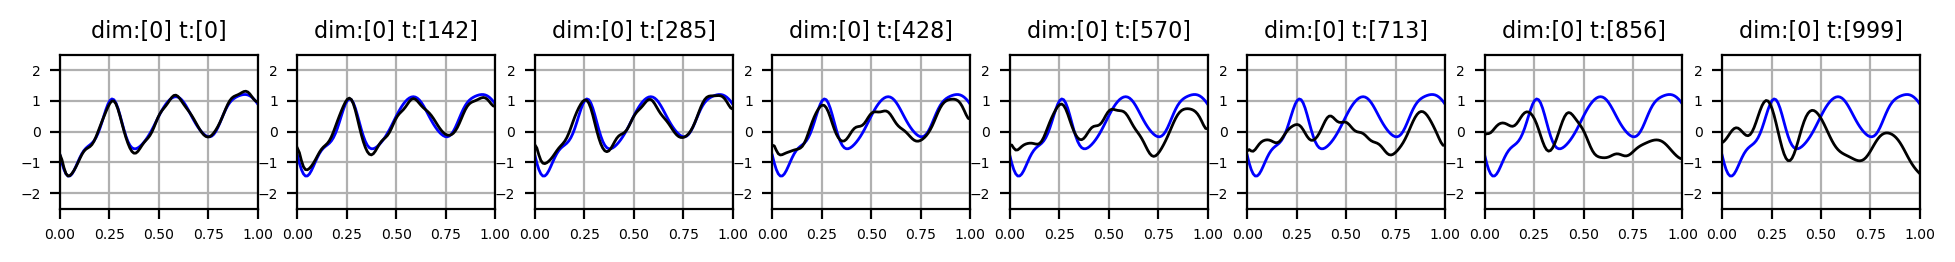

Done.


In [4]:
model.train()
# Optimize
MAX_ITER = 10000
optm = torch.optim.Adam(
    model.parameters(),lr=1e-3,betas=(0.9, 0.999),eps=1e-02,weight_decay=1e-08)
lr_schd = torch.optim.lr_scheduler.StepLR(optm,step_size=int(0.4*MAX_ITER),gamma=0.1)
device = 'cpu'
for it in range(MAX_ITER):
    optm.zero_grad()
    t = torch.randint(0, dc['T'],(BATCH_SIZE,),device=device).long() # [B]
    loss = get_ddpm_loss(
        model=model,x_0=x_batch,K_chols=K_chols,t=t,dc=dc,noise_rate=1.0,
        RKHS_projs=RKHS_projs,noise_type='Gaussian') # Gaussian / Uniform
    loss.backward(); optm.step(); lr_schd.step()
    if ((it % (MAX_ITER//10)) == 0) or (it==(MAX_ITER-1)):
        print ("[%d/%d][%.2f%%] loss:[%.3f]"%(it,MAX_ITER,100*it/MAX_ITER,loss.item()))
        eval_hddpm_1D(
            model,dc,K_chols,RKHS_projs,times,x_0,
            B=3,M=8,device='cpu',
            RKHS_PROJECTION_EACH_X_T=False)
print ("Done.")